In [671]:
import os
import json
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from mintpy import view
from mintpy.save_gmt import get_geo_lat_lon
from mintpy.utils import readfile, utils as ut, plot as pp
from mintpy.mask import mask_matrix

import cartopy.crs as ccrs
import cartopy.feature as cfeature

font_size=12
plt.rcParams.update({'font.size': font_size})

In [672]:
############# Least squares sover #########################################
def scipy_L2_reg(x, y, report=False):
    fit = stats.linregress(x, y)
    y_pred = fit.intercept + fit.slope * x
    if report:
        print('slope:', fit.slope)
        print('intercept:', fit.intercept)
    return fit, y_pred


############# Plotting utilities #########################################
def get_axis_aspect(ax):
    figW, figH = ax.get_figure().get_size_inches()
    # Axis size on figure
    _, _, w, h = ax.get_position().bounds
    # Ratio of display units
    disp_ratio = (figH * h) / (figW * w)
    return disp_ratio


def know_loc_from_subplots(fig, yoff=0.8):
    p = fig.subplotpars
    w, h = fig.get_size_inches()
    #figw = float(w)/(p.right - p.left)
    #figh = float(h)/(p.top   - p.bottom)
    yy = 1 + (yoff/h)
    return yy

def make_cbar_ax_side(fig, yloc='center', ch=1.0, cw_in=0.4):
    """
    yc          y center of the colorbar, in portion of the figure height
    ch          colorbar height, in portion of the figure height
    cw_in       colorbar width, in inches
    """
    y_bottom = 0.05416694
    y_top    = 0.94756917

    par  = fig.subplotpars
    w, h = fig.get_size_inches()
    #print(par.bottom, par.top)
    #print(y_bottom, y_top)

    cw   = cw_in / w
    cx   = 1 + cw
    if yloc == 'center':
        cy = 0.5 - ch/2
    elif yloc == 'top':
        cy = y_top - ch
    elif yloc == 'bottom':
        cy = y_bottom
    cbar_ax = fig.add_axes([cx, cy, cw, ch])
    return cbar_ax


def colorbar_inset(fig, ax, data, im, vlim=None, atr=None, cbar_inset=True, **kwargs):    
    # Initialize the kwargs
    if 'unit'            not in kwargs.keys():   kwargs['unit']           = ''
    if 'ub'              not in kwargs.keys():   kwargs['ub']             = 99.8
    if 'lb'              not in kwargs.keys():   kwargs['lb']             =   .2
    if 'cbox_alpha'      not in kwargs.keys():   kwargs['cbox_alpha']     = .9
    if 'cbox_hide'       not in kwargs.keys():   kwargs['cbox_hide']      = False
    if 'clabel_pad'      not in kwargs.keys():   kwargs['clabel_pad']     = 0.
    if 'corient'         not in kwargs.keys():   kwargs['corient']        = 'vertical'
    if 'unit_fontsize'   not in kwargs.keys():   kwargs['unit_fontsize']  = kwargs['font_size'] * .75
    if 'bound_fontsize'  not in kwargs.keys():   kwargs['bound_fontsize'] = kwargs['font_size'] * .7
    if 'ticks_fontsize'  not in kwargs.keys():   kwargs['ticks_fontsize'] = kwargs['font_size'] * .75
    if 'max_fontsize'    not in kwargs.keys():   kwargs['max_fontsize']   = 22
    if 'cbox_loc'        not in kwargs.keys():
        if kwargs['corient'] == 'horizontal':
                                                 kwargs['cbox_loc']       = (0., 0., .6, .08)
        elif kwargs['corient'] == 'vertical':
            if atr == None:
                                                 kwargs['cbox_loc']       = (1-.16, 0., .16, .3)
            else:
                if   atr['ORBIT_DIRECTION'].startswith('A'):
                                                 kwargs['cbox_loc']       = (1-.22, 1-.3, .22, .3)
                elif atr['ORBIT_DIRECTION'].startswith('D'):
                                                 kwargs['cbox_loc']       = (1-.22, 0., .22, .3)
    elif kwargs['cbox_loc'] is False:
        return
    if kwargs['corient'] == 'horizontal':
        text_rotate, ubx, uby, lbx, lby, uha, lha  = 0 , 0.98, 0.5,  0.02, 0.5, 'right', 'left'
        cbar_w, cbar_h = '80%', '50%'
        cbar_anchor    = (0, 0.15, 1, 1)
    elif kwargs['corient'] == 'vertical':
        text_rotate, ubx, uby, lbx, lby, uha, lha  = 270, 0.5 , 1.08, 0.5, -0.08, 'center', 'center'
        cbar_w, cbar_h = '20%', '74%'
        cbar_anchor    = (-.1, 0, 1, 1)        
        
    upper_val = np.nanpercentile(data, kwargs['ub'])
    lower_val = np.nanpercentile(data, kwargs['lb'])

    if cbar_inset:
        cbox = ax.inset_axes(kwargs['cbox_loc'], zorder=5)
        cbox.set_facecolor('w')
        cbox.patch.set_alpha(kwargs['cbox_alpha'])
        cbox.get_xaxis().set_visible(False)
        cbox.get_yaxis().set_visible(False)
        if kwargs['cbox_hide']:
            cbox.axis('off')
        cax = inset_axes(cbox, width=cbar_w, height=cbar_h, loc='center', bbox_transform=cbox.transAxes, bbox_to_anchor=cbar_anchor)
        kwargs['unit_fontsize']  = np.clip(a=kwargs['unit_fontsize'],  a_min=None, a_max=kwargs['max_fontsize']*0.9)
        kwargs['bound_fontsize'] = np.clip(a=kwargs['bound_fontsize'], a_min=None, a_max=kwargs['max_fontsize']*0.9)
        kwargs['ticks_fontsize'] = np.clip(a=kwargs['ticks_fontsize'], a_min=None, a_max=kwargs['max_fontsize'])
    else:
        cax = ax
        kwargs['unit_fontsize']  = plt.rcParams['font.size']
        kwargs['bound_fontsize'] = 0
        kwargs['ticks_fontsize'] = plt.rcParams['font.size']
    
    if vlim:
        fig.colorbar(im, cax=cax, orientation=kwargs['corient'], ticks=[vlim[0], np.mean(vlim), vlim[1]])
    else:
        fig.colorbar(im, cax=cax, orientation=kwargs['corient'])
    cax.text(0.5, 0.5, kwargs['unit'], ha='center', va='center', rotation=text_rotate, fontsize=kwargs['unit_fontsize'], transform=cax.transAxes)
    cax.text(lbx, lby, '({:.1f})'.format(lower_val), ha=lha, va='center', fontsize=kwargs['bound_fontsize'], transform=cax.transAxes)
    cax.text(ubx, uby, '({:.1f})'.format(upper_val), ha=uha, va='center', fontsize=kwargs['bound_fontsize'], transform=cax.transAxes)
    cax.tick_params(labelsize=kwargs['ticks_fontsize'], length=3, width=.5, colors='k')
    
    [sp.set_linewidth(0.5) for sp in cax.spines.values()]
    if kwargs['corient'] == 'horizontal':
        cax.xaxis.set_tick_params(pad=kwargs['clabel_pad'])
    if kwargs['corient'] == 'vertical':
        cax.yaxis.set_tick_params(pad=kwargs['clabel_pad'])


def scalebar_inset(fig, ax, inps, **kwargs):  
    # Initialize the kwargs
    if 'sloc'            not in kwargs.keys():   kwargs['sloc']         = 'lower left'
    if 'sbox_loc'        not in kwargs.keys():
        if   kwargs['sloc'] == 'upper left':    kwargs['sbox_loc']      = (0, 1-.05, .4, .05)
        elif kwargs['sloc'] == 'lower left':    kwargs['sbox_loc']      = (0, 0, .4, .06)
    elif kwargs['sbox_loc'] is False:
        return          
    if 'sbox_alpha'      not in kwargs.keys():  kwargs['sbox_alpha']    = .9
    if 'font_size'      not in kwargs.keys():   kwargs['font_size']     = kwargs['font_size'] * .8
    if 'scalebar_loc'   not in kwargs.keys():   kwargs['scalebar_loc']  = [0.3, kwargs['sbox_loc'][0]+0.2, kwargs['sbox_loc'][1]+.015]
    if 'scalebar_pad'   not in kwargs.keys():   kwargs['scalebar_pad']  = 0.02
    if 'coord_unit'     not in kwargs.keys():   kwargs['coord_unit']    = inps.coord_unit
    if 'geo_box'        not in kwargs.keys():   kwargs['geo_box']       = inps.geo_box    
    
    sbox = ax.inset_axes(kwargs['sbox_loc'], zorder=1)
    sbox.set_facecolor('w')
    sbox.patch.set_alpha(kwargs['sbox_alpha'])
    sbox.get_xaxis().set_visible(False)
    sbox.get_yaxis().set_visible(False)
    [sp.set_linewidth(.7) for sp in sbox.spines.values()]    
    ax = pp.draw_scalebar(ax, geo_box=inps.geo_box, unit=inps.coord_unit, loc=kwargs['scalebar_loc'], labelpad=kwargs['scalebar_pad'], font_size=kwargs['font_size'])

    
def annotation_inset(ax, annot, **kwargs):
    ratio = get_axis_aspect(ax)
    # Initialize the kwargs
    if 'annot_boxsize' not in kwargs.keys():   kwargs['annot_boxsize'] = 0.1
    if 'annot_lw'      not in kwargs.keys():   kwargs['annot_lw']      = 0.5
    boxsize = kwargs['annot_boxsize']
    annot_loc = (0, 1-boxsize, boxsize*ratio, boxsize)
    abox = ax.inset_axes(annot_loc, zorder=10)
    abox.set_facecolor('w')
    abox.get_xaxis().set_visible(False)
    abox.get_yaxis().set_visible(False)
    abox.text(0.5, 0.5, annot, fontsize=12, transform=abox.transAxes, va='center', ha='center')
    [sp.set_linewidth(kwargs['annot_lw']) for sp in abox.spines.values()]


def satellite_inset(fig, ax, atr, **kwargs):   
    # Initialize the kwargs
    if 'font_size'  not in kwargs.keys():   kwargs['font_size']     = kwargs['font_size'] * .8
    if 'quiver_w'   not in kwargs.keys():   kwargs['quiver_w']      = 0.04
    if 'box_show'   not in kwargs.keys():   kwargs['box_show']      = 'on'
    if 'box_color'  not in kwargs.keys():   kwargs['box_color']     = 'w'
    if 'tbox_alpha' not in kwargs.keys():  kwargs['tbox_alpha']     = .9
    if 'sat_az_qsc' not in kwargs.keys():   kwargs['sat_az_qsc']    = 1.
    if 'sat_rg_qsc' not in kwargs.keys():   kwargs['sat_rg_qsc']    = kwargs['sat_az_qsc'] * 2.4
    if 'sat_label'  not in kwargs.keys():   kwargs['sat_label']     = 'rg' # rg, az, both, los
    if 'sat_corner' not in kwargs.keys():   kwargs['sat_corner']    = True

    if 'tbox_loc'   not in kwargs.keys():
        if atr == None:
                                            kwargs['tbox_loc']      = (1-.15, 1-.1, .15, .1)
        else:
            if   atr['ORBIT_DIRECTION'].startswith('A'):
                                            kwargs['tbox_loc']      = (0, .06, .15, .13)
            elif atr['ORBIT_DIRECTION'].startswith('D'):
                if kwargs['sat_corner'] is True:
                                            kwargs['tbox_loc']      = (1-.15, 0, .15, .13)
                elif kwargs['sat_corner'] == 'upperright':
                                            kwargs['tbox_loc']      = (1-.15, 1-.13, .15, .13)
                else:
                                            kwargs['tbox_loc']      = (1-.15, .3, .15, .13)
    elif kwargs['tbox_loc'] is False:
        return                         
    
    tbox = ax.inset_axes(kwargs['tbox_loc'], zorder=5)
    tbox.set_facecolor(kwargs['box_color'])
    tbox.patch.set_alpha(kwargs['tbox_alpha'])
    tbox.get_xaxis().set_visible(False)
    tbox.get_yaxis().set_visible(False)
    tbox.axis(kwargs['box_show'])
    [sp.set_linewidth(.7) for sp in tbox.spines.values()]
    

    head_rad = np.deg2rad(float(atr['HEADING']))
    look_rad = np.deg2rad(float(atr['HEADING'])+90.)
    fly      = np.array([np.sin(head_rad), np.cos(head_rad)])
    look     = np.array([np.sin(look_rad), np.cos(look_rad)])

    if atr['ORBIT_DIRECTION'].startswith('A'):
        tail        = np.array([0.4, 0.15])
        rot_rg      = 90 - np.rad2deg(look_rad)
        rot_az      = rot_rg - 90
        text_rg     = [.1, 0]
        text_az     = [-.16, +.48]
        va, ha      = 'top', 'left'
    elif atr['ORBIT_DIRECTION'].startswith('D'):
        tail        = np.array([0.78, 0.75])
        rot_rg      = 270 - np.rad2deg(look_rad)
        rot_az      = rot_rg + 90
        text_rg     = [0, .08]
        text_az     = [-.1, -.38]
        va, ha      = 'bottom', 'right'

    peg = tail + .22*fly*(1/kwargs['sat_az_qsc'])
    tbox.quiver(tail[0], tail[1], fly[0], fly[1], transform=tbox.transAxes, scale=kwargs['sat_az_qsc'], scale_units='width', width=kwargs['quiver_w'])

    # draw range arrow
    if kwargs['sat_label'] == 'los':
        u, v, pivot, label = -look[0], -look[1], 'tip', kwargs['sat_label'].upper()
        tbox.quiver(*peg, u, v, transform=tbox.transAxes, scale=kwargs['sat_rg_qsc'], scale_units='width', width=kwargs['quiver_w'], pivot=pivot)
        tbox.text(*peg+text_rg, label, fontsize=kwargs['font_size'], transform=tbox.transAxes, rotation=rot_rg, va=va, ha=ha)
    elif kwargs['sat_label'] == 'rg':
        u, v, pivot = look[0], look[1], 'tail'
        tbox.quiver(*peg, u, v, transform=tbox.transAxes, scale=kwargs['sat_rg_qsc'], scale_units='width', width=kwargs['quiver_w'], pivot=pivot)
        tbox.text(*peg+text_rg, 'rg', fontsize=kwargs['font_size'], transform=tbox.transAxes, rotation=rot_rg, va=va, ha=ha)
        tbox.text(*peg+text_az, 'az', fontsize=kwargs['font_size'], transform=tbox.transAxes, rotation=rot_az, va=va, ha=ha)


def axe_bound_from_atr(atr):
    """
    atr:     mintpy .h5 attributes
    trim:    trim a fraction of x-axis and y-axis (None or 0.01) for weird white space
    """
    N = float(atr['Y_FIRST'])
    S = float(atr['Y_FIRST']) + float(atr['Y_STEP']) * (int(atr['LENGTH'])-1)
    W = float(atr['X_FIRST'])
    E = float(atr['X_FIRST']) + float(atr['X_STEP']) * (int(atr['WIDTH'])-1)
    return S, N, W, E
    
    
def depth(lst):
    if not isinstance(lst, list):
        return 0
    else:
        return 1 + max(depth(sublist) for sublist in lst)

    
def save_fig(fig, outfile, **kwargs):
    # Normalize a pathname by collapsing redundant separators and up-levels
    outfile = os.path.normpath(outfile)

    # create outdir if not exists
    outdir = os.path.dirname(outfile)
    ext = os.path.splitext(outfile)[-1].split('.')[-1]
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    w, h = fig.get_size_inches()
    dpi = kwargs['dpi']
    print('Figure ext:{} dpi:{} W/H:{:.2f}/{:.2f}'.format(ext, dpi, w*dpi, h*dpi))
    print('Save to file: {}'.format(outfile))
    if ext == 'pdf':
        fig.savefig(outfile, dpi=dpi, bbox_inches='tight', format=ext)
    else:
        fig.savefig(outfile, transparent=True, dpi=dpi, bbox_inches='tight', format=ext)
    
    
    
############# Files & Data information #########################################
def remove_modes(data, N=50):
    # mask the weird pixels by identifying modes
    new_data     = np.array(data)
    vals, counts = np.unique(data, return_counts=True)
    index        = np.argsort(counts, axis=0)[::-1]
    modes        = np.where(counts[index]>N)[0]
    if len(modes)>0:
        #print('Set weird modes to NaN: {}'.format(key))
        for m in modes:
            #print('  Count: {} \t value: {}'.format(counts[index[m]], vals[index[m]]))
            new_data[data==vals[index[m]]] = np.nan
    return new_data


def apply_mask(data, mask, atr=None):
    if mask == 'zero':
        print('Maksing zeros')
        msk_bool = 1*(data!=0.0)
        msk_bool[int(atr['REF_Y']), int(atr['REF_X'])] = 1
    else:
        msk_bool = readfile.read(mask)[0]
    # apply mask
    new_data = mask_matrix(data, msk_bool, fill_value=np.nan)
    return new_data


def compute_ground_range(atr, rs, z):
    """
    atr     MintPy attributes from e.g., gemetryGeo.h5
    rs      slant range distance [m]
    z       DEM elevation [m]
    """

    Re    = float(atr['EARTH_RADIUS'])    # approx. Earth's radius
    h     = float(atr['HEIGHT'])          # satellite height

    # angle at the center of the Earth
    gamma = np.arccos(( (Re+h)**2 + (Re+z)**2 - rs**2 ) / ( 2*(Re+h)*(Re+z) ))

    # set the zero ground range at the nearest range pixel
    rg  = Re * gamma   # ground range
    rg -= np.nanmin(rg)
    return rg


def prepare_range_geometry(geom_file):
    """Prepare LOS geometry data/info in geo-coordinates
    Parameters: geom_file  - str, path of geometry file
    Returns:    range_s    - 2D np.ndarray, slant range distace in km
                range_g    - 2D np.ndarray, ground range distance in km
                atr        - dict, metadata in geo-coordinate
    """
    print('prepare range distance in geo-coordinates from file: {}'.format(geom_file))
    atr = readfile.read_attribute(geom_file)
    if 'slantRangeDistance' in readfile.get_dataset_list(geom_file):
        range_s  = readfile.read(geom_file, datasetName='slantRangeDistance')[0]
        height   = readfile.read(geom_file, datasetName='height')[0]
        range_g = compute_ground_range(atr, range_s, height)
        range_s  /= 1e3
        range_g /= 1e3
    return range_s, range_g, atr


def prepare_data_ion(inDict):
    v = dict()
    atr = readfile.read(inDict['velo2'], datasetName='velocity')[1]
    v['Velocity1']    = readfile.read(inDict['velo1'],    datasetName='velocity')[0]
    v['VelocityIon']  = readfile.read(inDict['veloIon'],  datasetName='velocity')[0]
    v['Velocity2']    = readfile.read(inDict['velo2'],    datasetName='velocity')[0]
    
    gfile = inDict['geo']
    range_s, range_g = prepare_range_geometry(gfile)[:2]
    lats, lons = get_geo_lat_lon(atr)
    Lons, Lats = np.meshgrid(lons, lats)
    
    for k in v: # convert to mm/yr and remove the median for referencing
        v[k] = (v[k] - np.nanmedian(v[k])) * 1000.

    if 'mask' in inDict:
        v['Velocity1']   = apply_mask(v['Velocity1'],   inDict['mask'], atr=atr)
        v['VelocityIon'] = apply_mask(v['VelocityIon'], inDict['mask'], atr=atr)        
        v['Velocity2']   = apply_mask(v['Velocity2'],   inDict['mask'], atr=atr)
    
    demfile = inDict['dem']
    return v, range_g, Lats, Lons, demfile, atr


def prepare_data_bm(inDict):
    v = dict()
    atr = readfile.read(inDict['velo2'], datasetName='velocity')[1]
    v['Velocity2']          = readfile.read(inDict['velo2'],       datasetName='velocity')[0]
    v['Plate motion']       = readfile.read(inDict['bmModel'],     datasetName='velocity')[0]
    v['Corrected velocity'] = readfile.read(inDict['velo_bmCorr'], datasetName='velocity')[0]
    
    gfile = inDict['geo']
    range_s, range_g = prepare_range_geometry(gfile)[:2]
    lats, lons = get_geo_lat_lon(atr)
    Lons, Lats = np.meshgrid(lons, lats)
    
    for k in v: # convert to mm/yr and remove the median for referencing
        v[k] = (v[k] - np.nanmedian(v[k])) * 1000.

    if 'mask' in inDict:
        v['Velocity2']          = apply_mask(v['Velocity2'], inDict['mask'], atr=atr)
        v['Corrected velocity'] = apply_mask(v['Corrected velocity'], inDict['mask'], atr=atr)
    
    demfile = inDict['dem']
    return v, range_g, Lats, Lons, demfile, atr    
    
    
def prepare_data_order(inDict):
    v = dict()
    v['Uncorrected velocity']     = readfile.read(inDict['velo_raw'],    datasetName='velocity')[0]
    v['Ionosphere removed']       = readfile.read(inDict['velo_ion'],    datasetName='velocity')[0]
    v['Tropo model removed']      = readfile.read(inDict['velo_ERA5'],   datasetName='velocity')[0]
    v['Solid Earth tide removed'] = readfile.read(inDict['velo_SET'],    datasetName='velocity')[0]
    v['DEM error removed']        = readfile.read(inDict['velo_demErr'], datasetName='velocity')[0]

    v['Plate motion']             = readfile.read(inDict['velo_bmModel'], datasetName='velocity')[0]
    v['Plate motion removed']     = readfile.read(inDict['velo_bmCorr'],  datasetName='velocity')[0]    
    
    v['SET & DEM error removed']  = v['DEM error removed']
    v['Ionosphere']               = - (v['Ionosphere removed']       -  v['Uncorrected velocity'])
    v['Troposphere']              = - (v['Tropo model removed']      -  v['Ionosphere removed'])
    v['SET']                      = - (v['Solid Earth tide removed'] -  v['Tropo model removed'])
    v['DEM error']                = - (v['DEM error removed']        -  v['Solid Earth tide removed'])

    atr = readfile.read(inDict['velo_raw'])[1]
    demfile = inDict['dem']
    
    for k in v:
        v[k] = (v[k] - np.nanmedian(v[k])) * 1000.
    
    return v, demfile, atr



############# Major plotting functions #########################################

def plot_range_ramp(data1, data2=None, range_dist=None, latitude=None, super_title=None, plot=True, outfile=False, **kwargs):
    # Initialize the kwargs  
    if 'subplot_w'  not in kwargs.keys():   kwargs['subplot_w']   = 7.
    if 'cmap'       not in kwargs.keys():   kwargs['cmap']        = 'plasma'
    if 'alpha'      not in kwargs.keys():   kwargs['alpha']       = 0.5
    if 'vlim'       not in kwargs.keys():   kwargs['vlim']        = [None,None]
    if 'titstr'     not in kwargs.keys():   kwargs['titstr']      = ''
    if 'title_pad'  not in kwargs.keys():   kwargs['title_pad']   = 5.
    if 'range_type' not in kwargs.keys():   kwargs['range_type']  = None
    if 'slope_norm' not in kwargs.keys():   kwargs['slope_norm']  = 'L2'
    if 'flipud'     not in kwargs.keys():   kwargs['flipud']      = True
    if 'fliplr_auto'not in kwargs.keys():   kwargs['fliplr_auto'] = True

    
    # compare different inputs
    if data2 is not None:
        if data1.shape == data2.shape:
            ncols = 3
            if isinstance(kwargs['titstr'], str):
                kwargs['titstr'] = ['Data LOS velocity',
                                    'Plate bulk motion LOS projection',
                                    'Corrected LOS velocity']
    else:
        ncols = 1

    # get range and azimuth bins
    length, width = data1.shape
    rbins = np.tile(np.arange(width), (length, 1))
    abins = np.tile(np.arange(length), (width, 1)).T

    # range_bin, groundRangeDistance, or slantRangeDistance for x-axis
    if range_dist is None:
        xarry      = np.array(rbins)
        yarry      = np.array(abins)
        xlabel     = 'Range bin'
        ylabel     = 'Azimuth bin'
        slope_unit = 'mm/yr/track'
        factor     = float(width)
    else:
        xarry      = np.array(range_dist)
        xlabel     = '{} range [km]'.format(kwargs['range_type'].title())
        slope_unit = 'mm/yr/km'
        factor     = 1.0
        if latitude is None:
            yarry  = np.array(abins)
            ylabel = 'Azimuth bin'
        else:
            yarry  = np.array(latitude)
            ylabel = r'Latitude [$^\circ$]'

    # flip all arrays up-down (scatter plot the points at larger y-axis first)
    if kwargs['flipud']:
        xarry = np.flipud(xarry)
        yarry = np.flipud(yarry)
        data1 = np.flipud(data1)
        data2 = np.flipud(data2)

    # flip all arrays left-right (descending range flip to align with rough East-West)
    if kwargs['fliplr_auto']:
        tmp = np.nanmean(xarry, axis=0)
        if tmp[0] > tmp[-1]:
            xlim = [250,0]
            xticks = np.flip(np.arange(50,250,50))            
        else:
            xlim = [0,250]
            xticks = np.arange(50,250,50)
            
    # Plot single scatter plot
    if ncols == 1:
        if plot:
            # Set the figure
            fig, ax = plt.subplots(figsize=[kwargs['subplot_w'], kwargs['subplot_w']*0.8], ncols=ncols, sharey=True)
        x = xarry.flatten()[~np.isnan(data1.flatten())]
        y = data1.flatten()[~np.isnan(data1.flatten())]
        c = yarry.flatten()[~np.isnan(data1.flatten())]
        y = y - np.nanmedian(y)
        print('Range ramp scatter plot shifted by median {}'.format(np.nanmedian(y)))
        print('Ground range min/max:', np.nanmin(xarry), np.nanmax(xarry))
        print('Valid (non-nan pixels) ground range min/max:', np.nanmin(x), np.nanmax(x))

        # linear fit to the trend
        if kwargs['slope_norm'] == 'L2':
            fit, y_pred  = scipy_L2_reg(x, y)
            params_legend = 'y=ax+b, a={:.3f} ± {:.2e}\n'.format(fit[0], fit.stderr)
        elif kwargs['slope_norm'] == 'L1':
            fit, y_pred  = cvxpy_reg(x, y, p=1)
            params_legend = 'y=ax+b, a={:.3f}\n'.format(fit[0])

        if range_dist is None:
            params_legend += 'slope = {:.3f} {:s}'.format(fit[0]*factor, slope_unit)
        else:
            range_span = np.max(x) - np.min(x)
            print('{} range distance spans {:.1f} km'.format(kwargs['range_type'].title(), range_span))
            params_legend += 'slope = {:.3f} {:s}'.format(fit[0]*factor, slope_unit)
            show_legend    = '{:.1f}\nmm/yr/track'.format(fit[0]*range_span)
            params_legend += '\n'+show_legend

        if plot:
            sc = ax.scatter(x, y, s=0.5, c=c, cmap=kwargs['cmap'], alpha=kwargs['alpha'])
            sc.set_rasterized(True)
            ax.plot(x, y_pred, lw=1.5, label=show_legend, c='r')
            #ax.legend(loc='lower left', frameon=False)
            #ax.set_xlabel(xlabel)
            #ax.set_ylabel('LOS velocity [mm/yr]')
            #cbar = plt.colorbar(sc, ax=ax)
            #cbar.ax.set_ylabel(ylabel='Azimuth', rotation=270, labelpad=10)
            #cbar.solids.set(alpha=1)
            ax.set_title(kwargs['titstr'], fontsize=plt.rcParams['font.size'], pad=kwargs['title_pad'])
            ax.set_ylim(kwargs['vlim'][0], kwargs['vlim'][1])
            ax.set_xticks([100,200])
            ax.set_xlim(xlim)
            ax.yaxis.set_major_locator(MaxNLocator(3))
            #ax.xaxis.set_major_locator(MaxNLocator(2))
            ax.tick_params(direction='in', length=5, width=.7, colors='k', top=True, right=True)
            ax.tick_params(axis="y", pad=-14)
            ax.tick_params(axis="x", pad=-14)
            
            [sp.set_linewidth(2) for sp in ax.spines.values()]
            [sp.set_zorder(10)   for sp in ax.spines.values()]
            plt.show()

    # Plot scatter plots comparison
    if ncols == 3:
        if plot:
            # Set the figure
            fig, axs = plt.subplots(figsize=[kwargs['subplot_w'], 1.2*kwargs['subplot_w']/ncols], ncols=ncols, sharey=True, gridspec_kw={'wspace':.03}, constrained_layout=True)

        for i, (ax, data) in enumerate(zip(axs, [data1, data2, data1-data2])):
            x = xarry.flatten()[~np.isnan(data.flatten())]
            y =  data.flatten()[~np.isnan(data.flatten())]
            c = yarry.flatten()[~np.isnan(data.flatten())]
            y = y - np.nanmedian(y)
            print('Range ramp scatter plot shifted by median {}'.format(np.nanmedian(y)))
            print('Ground range min/max:', np.nanmin(xarry), np.nanmax(xarry))
            print('Valid (non-nan pixels) ground range min/max:', np.nanmin(x), np.nanmax(x))

            # linear fit to the trend
            if kwargs['slope_norm'] == 'L2':
                fit, y_pred  = scipy_L2_reg(x, y)
                params_legend = 'y=ax+b, a={:.3f} ± {:.2e}\n'.format(fit[0], fit.stderr)
            elif kwargs['slope_norm'] == 'L1':
                fit, y_pred  = cvxpy_reg(x, y, p=1)
                params_legend = 'y=ax+b, a={:.3f}\n'.format(fit[0])

            if range_dist is None:
                params_legend += 'slope = {:.3f} {:s}'.format(fit[0]*factor, slope_unit)
            else:
                range_span = np.max(x) - np.min(x)
                print('{} range distance spans {:.1f} km'.format(kwargs['range_type'].title(), range_span))
                params_legend += 'slope = {:.3f} {:s}'.format(fit[0]*factor, slope_unit)
                show_legend    = '{:.1f}\nmm/yr/track'.format(fit[0]*range_span)
                params_legend += '\n'+show_legend

            if plot:
                sc = ax.scatter(x, y, s=0.5, c=c, cmap=kwargs['cmap'], alpha=kwargs['alpha'])
                sc.set_rasterized(True)
                ax.plot(x, y_pred, lw=1.5, label=show_legend, c='crimson')
                ax.legend(loc='lower left', markerscale=0.5, frameon=False)
                ax.set_xlabel(xlabel)
                ax.set_ylabel('LOS velocity [mm/yr]')
                ax.set_title(kwargs['titstr'][i], fontsize=plt.rcParams['font.size'], pad=kwargs['title_pad'])
                ax.set_ylim(kwargs['vlim'][0], kwargs['vlim'][1])
                ax.set_xlim(xlim)
                ax.set_xticks(xticks)
                ax.yaxis.set_major_locator(MaxNLocator(5))
                ax.tick_params(direction='in', length=6, width=1, colors='k', top=True, right=True)
                [sp.set_linewidth(1) for sp in ax.spines.values()]
                [sp.set_zorder(10)   for sp in ax.spines.values()]
                if i>0:
                    ax.tick_params(labelleft=False)
                    ax.set(ylabel=None)                
                    
                cbar = plt.colorbar(sc, ax=ax)
                cbar.ax.set_ylabel(ylabel=ylabel, rotation=270, labelpad=12)
                cbar.solids.set(alpha=1)
                [sp.set_linewidth(1) for sp in cbar.ax.spines.values()]                    

        if plot:
            if super_title:
                sup_y = know_loc_from_subplots(fig, yoff=0.8)
                fig.suptitle(super_title, fontsize=plt.rcParams['font.size'], y=sup_y)


    # Save figure
    if outfile:
        save_fig(fig, outfile, dpi=400)

    if plot:
        plt.show()

    return



def plot_imgs(v, atr, dem, titles=None, super_title=None, row_title=None, outfile=False, **kwargs):
    # Initialize the kwargs
    if 'coord'      not in kwargs.keys():   kwargs['coord']         = 'geo'
    if 'refpoint'   not in kwargs.keys():   kwargs['refpoint']      = False
    if 'wspace'     not in kwargs.keys():   kwargs['wspace']        = 0.1
    if 'subplot_w'  not in kwargs.keys():   kwargs['subplot_w']     = 12.
    if 'sharey'     not in kwargs.keys():   kwargs['sharey']        = True
    if 'vlims'      not in kwargs.keys():   kwargs['vlims']         = [None,None]
    if           kwargs['vlims'] is None:   kwargs['vlims']         = [None,None]
    if 'font_size'  not in kwargs.keys():   kwargs['font_size']     = plt.rcParams['font.size']
    if 'font_size_Row' not in kwargs.keys(): kwargs['font_size_Row'] = plt.rcParams['font.size']    
    if 'suptity'    not in kwargs.keys():   kwargs['suptity']       = .8
    if 'units'      not in kwargs.keys():   kwargs['units']         = 'mm/year'
    if 'alpha'      not in kwargs.keys():   kwargs['alpha']         = 0.78
    if 'cmap'       not in kwargs.keys():   kwargs['cmap']          = 'RdBu_r'
    if 'one_cbar'   not in kwargs.keys():   kwargs['one_cbar']      = False    
    if 'side_cbar'  not in kwargs.keys():   kwargs['side_cbar']     = False
    if 'legend_ax'  not in kwargs.keys():   kwargs['legend_ax']     = -1
    if 'shadeExg'   not in kwargs.keys():   kwargs['shadeExg']      = 0.06
    if 'shadeMin'   not in kwargs.keys():   kwargs['shadeMin']      = -3e3
    if 'shadeMax'   not in kwargs.keys():   kwargs['shadeMax']      =  5e3
    if 'laloStep'   not in kwargs.keys():   kwargs['laloStep']      = 1
    if 'yticks'     not in kwargs.keys():   kwargs['yticks']        = None
    if 'xticks'     not in kwargs.keys():   kwargs['xticks']        = None
    if 'tick_params'not in kwargs.keys():   kwargs['tick_params']   = ['in', -14, -25, 
                                                                       True, False, False, True, 
                                                                       'center', 'center']
    if 'coastline'  not in kwargs.keys():   kwargs['coastline']     = '10m'
    if 'coast_lw'   not in kwargs.keys():   kwargs['coast_lw']      = 0.8
    if 'pts-marker' not in kwargs.keys():   kwargs['pts-marker']    = 'k^'
    if 'pts_ms'     not in kwargs.keys():   kwargs['pts_ms']        = 6.0
    if 'pts_yx'     not in kwargs.keys():   kwargs['pts_yx']        = None
    if 'pts_lalo'   not in kwargs.keys():   kwargs['pts_lalo']      = None
    if 'pts_file'   not in kwargs.keys():   kwargs['pts_file']      = None
    if 'title_pad'  not in kwargs.keys():   kwargs['title_pad']     = 16
    if 'annotation' not in kwargs.keys():   kwargs['annotation']    = None
    if 'dpi'        not in kwargs.keys():   kwargs['dpi']           = 300


    # Set the figure
    nrows, ncols    = 1, len(v)
    im_dim          = list(v.values())[0].shape
    fat             = im_dim[1]/im_dim[0]
    subplot_kw      = dict(projection=ccrs.PlateCarree())
    gridspec_kw     = { 'wspace'                :   kwargs['wspace']}
    fig_kw          = { 'figsize'               :   [kwargs['subplot_w'], 1.5*kwargs['subplot_w']/fat/ncols],
                        'constrained_layout'    :   True}

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharey=kwargs['sharey'], gridspec_kw=gridspec_kw, subplot_kw=subplot_kw, **fig_kw)

    # specs for different subplots
    if len(v) == 1:
        axs = [axs]
    if depth(kwargs['vlims']) == 1:
        kwargs['vlims'] = [kwargs['vlims']]
    if len(kwargs['vlims']) != len(axs):
        kwargs['vlims'] = [kwargs['vlims'][-1]]*len(axs)
    if isinstance(kwargs['units'], str):
        kwargs['units'] = [kwargs['units']]
    if len(kwargs['units']) != len(axs):
        kwargs['units'] = [kwargs['units'][-1]]*len(axs)
        
    if kwargs['one_cbar'] is None:
        if kwargs['vlims'].count(kwargs['vlims'][0]) == len(kwargs['vlims']):
            if not any(kwargs['vlims'][0]):
                kwargs['one_cbar'] = False
            else:
                print('only show one common colorbar in the first subplot')
                kwargs['one_cbar'] = True
        else:
            kwargs['one_cbar'] = False


    # get axis bound
    S, N, W, E = axe_bound_from_atr(atr)

    # view.py options
    cmd0 = f" view.py {atr['FILE_PATH']} velocity --fontsize {int(kwargs['font_size'])} "
    opt  = f" --mask no --dem {dem} --dem-nocontour -c {kwargs['cmap']} --nocbar "
    opt += f" --alpha {kwargs['alpha']} --shade-exag {kwargs['shadeExg']} --shade-min {kwargs['shadeMin']} --shade-max {kwargs['shadeMax']} "
    opt += f" --lalo-step {kwargs['laloStep']} --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose "

    # plot coastline
    if  kwargs['coastline']:
        opt += f" --coastline {kwargs['coastline']} --coastline-lw {kwargs['coast_lw']}"

    # plot points of interests
    if kwargs['pts_yx'] or kwargs['pts_lalo'] or kwargs['pts_file']:
        opt += f" --pts-marker {kwargs['pts_marker']} --pts-ms {kwargs['pts_ms']} \
                  --pts-yx {kwargs['pts_yx']} --pts-lalo {kwargs['pts_lalo']} --pts-file {kwargs['pts_file']} "

    # plot/modify the reference point if available
    if (kwargs['refpoint'] is not False) and (all(ii in atr for ii in ['REF_LAT', 'REF_LON'])):
        opt += f" --ref-lalo {atr['REF_LAT']} {atr['REF_LON']} "
    elif kwargs['refpoint'] is  False:
        opt += " --noreference "

    keys = v.keys()
    # plot each field
    for i, (ax, k, vlim, unit) in enumerate(zip(axs, keys, kwargs['vlims'], kwargs['units'])):
        print('Plot data no. {}: <{}>'.format(i+1, k))
        data = v[k]

        # view.py cmd
        ui = unit.split('/')[0]
        if not any(vlim):
            cmd  = f" {cmd0} -u {ui} " + opt
        else:
            cmd  = f" {cmd0} -u {ui} -v {vlim[0]} {vlim[1]} " + opt

        inps = view.prep_slice(cmd)[2]

        # plot the slice
        ax, inps, im, _ = view.plot_slice(ax, data, atr, inps)
        im.set_rasterized(True)

        # add ocean and lakes from cartopy features
        ax.add_feature(cfeature.OCEAN, zorder=.5, alpha=.7)
        ax.add_feature(cfeature.LAKES, zorder=.5, alpha=.7)

        # plot colorbar in subplots
        if not kwargs['side_cbar']:
            if kwargs['one_cbar'] is False:
                colorbar_inset(fig, ax, data, im, vlim, atr, unit=inps.disp_unit, **kwargs)
            else:
                if i == len(axs)-1:
                    colorbar_inset(fig, ax, data, im, vlim, atr, unit=inps.disp_unit, bound_fontsize=0, **kwargs)

        # labeling the figure
        if inps.coord_unit == 'radar':
            ax.set_xlabel('Range pixel',   fontsize=kwargs['font_size'])
            ax.set_ylabel('Azimuth pixel', fontsize=kwargs['font_size'])
        
        if titles is not False:
            if titles is None:
                tit_str = str(k)
            else:
                tit_str = titles[i]
            ax.set_title(tit_str, fontsize=kwargs['font_size'], pad=kwargs['title_pad'])
        if kwargs['yticks']:  ax.set_yticks(kwargs['yticks'])
        if kwargs['xticks']:  ax.set_xticks(kwargs['xticks'])        
        ax.set_xlim([W, E])
        ax.set_ylim([S, N])
        tdir, xpad, ypad, l, r, b, t, xha, yva = kwargs['tick_params']
        ax.tick_params(axis="x", direction=tdir, pad=xpad, labelleft=l, labelright=r, labelbottom=b, labeltop=t)
        ax.tick_params(axis="y", direction=tdir, pad=ypad, labelleft=l, labelright=r, labelbottom=b, labeltop=t)
        for lab in ax.xaxis.get_ticklabels(): lab.set_horizontalalignment(xha)        
        for lab in ax.yaxis.get_ticklabels(): lab.set_verticalalignment(yva)
        if i>0 and kwargs['sharey']:  ax.tick_params(labelleft=False, labelright=False)
            
        # set width of ticks & border
        ax.tick_params(length=5, width=.7, colors='k')
        [sp.set_linewidth(.7) for sp in ax.spines.values()]
        [sp.set_zorder(10)    for sp in ax.spines.values()]
        
        # scale bar, LoS legend, mute common y-axis
        if kwargs['legend_ax'] == -1: kwargs['legend_ax']=len(axs)-1
        kwargs['legend_ax'] = int(np.clip(kwargs['legend_ax'], a_min=0, a_max=len(axs)-1))
        if i == kwargs['legend_ax']:
            scalebar_inset(fig,  ax, inps, **kwargs)
            satellite_inset(fig, ax, atr, sat_corner=kwargs['one_cbar'], **kwargs)
            
        if row_title and i==0:
            ax.set_ylabel(row_title, fontsize=kwargs['font_size_Row'])

    # Add super title
    if super_title:
        sup_y = know_loc_from_subplots(fig, yoff=kwargs['suptity'])
        fig.suptitle(super_title, fontsize=kwargs['font_size'], y=sup_y)

    # Plot the common colorbar by the side
    if kwargs['side_cbar']:
        cax = make_cbar_ax_side(fig, yloc='center', ch=0.5, cw_in=0.3)
        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.set_ylabel(ylabel=inps.disp_unit, rotation=270, labelpad=28)
        
    if kwargs['annotation']:
        for ax, annot in zip(axs, kwargs['annotation']):
            annotation_inset(ax, annot, **kwargs)

    # Save figure
    if outfile:
        save_fig(fig, outfile, **kwargs)

    plt.show()


In [673]:
datahome = '/net/kraken/nobak/ykliu/2022-BulkMotion/in_h5'
picdir   = '/net/kraken/nobak/ykliu/2022-BulkMotion/pic'
my_json  = '/net/kraken/nobak/ykliu/2022-BulkMotion/inputs/brief.json'

# Makran A086: A series of corrections

In [674]:
vDict = {
            "geo"         : f"{datahome}/Makran_a086_Geo.h5",
            "dem"         : f"{datahome}/Makran_a086.dem",
            "velo_raw"    : f"{datahome}/Makran_a086_velR.h5",
            "velo_ion"    : f"{datahome}/Makran_a086_velR_ion.h5",
            "velo_ERA5"   : f"{datahome}/Makran_a086_velR_ion_ERA5.h5",
            "velo_SET"    : f"{datahome}/Makran_a086_velR_ion_ERA5_SET.h5",
            "velo_demErr" : f"{datahome}/Makran_a086_velR_ion_ERA5_SET_demErr.h5",
            "velo_bmModel": f"{datahome}/Makran_a086_vel_bmModel.h5",
            "velo_bmCorr" : f"{datahome}/Makran_a086_vel_bmCorr.h5"
            }

v, demfile, atr = prepare_data_order(vDict)

In [675]:
## Set common plotting specs

w_cm  = 19       # max width of GRL figure
l_cm  = 11.5     # not used
cm2in = 1/2.54  # mm to inches

kwargs = dict()
kwargs['subplot_w'] = w_cm*cm2in
kwargs['font_size'] = 8
kwargs['laloStep']  = 2
kwargs['wspace']    = 0.
kwargs['title_pad'] = 4
kwargs['suptity']   = 0.1
kwargs['alpha']     = 0.85
kwargs['shadeExg']  = 0.05
kwargs['shadeMin']  = -5e3
kwargs['shadeMax']  =  5e3
kwargs['refpoint']  = False
kwargs['dpi']       = 600
kwargs['cmap']      = 'RdYlBu_r'
kwargs['corient']       = 'horizontal'
kwargs['cbox_loc']      = (0., 0.-.125, 1, .1)
kwargs['cbox_hide']     = True
kwargs['clabel_pad']    = 0.4
kwargs['sbox_loc']      = (0, 0, .4, .09)
kwargs['scalebar_loc']  = [0.3, kwargs['sbox_loc'][0]+0.2, kwargs['sbox_loc'][1]+.015]
kwargs['scalebar_pad']  = 0.04
kwargs['tbox_loc']      = (0, kwargs['sbox_loc'][3], .18, .16)
kwargs['annot_boxsize'] = 0.1
kwargs['yticks'] = [26., 28., 30.]
kwargs['xticks'] = [60., 62.]

Plot data no. 1: <Uncorrected velocity>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a086_velR.h5 velocity --fontsize 8 -u mm -v -20 20 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a086.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.05 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.8 --noreference
Plot data no. 2: <Ionosphere removed>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a086_velR.h5 velocity --fontsize 8 -u mm -v -5 5 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a086.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.05 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.8 --noreference
Plot data no. 3: <Tropo model removed>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Mak

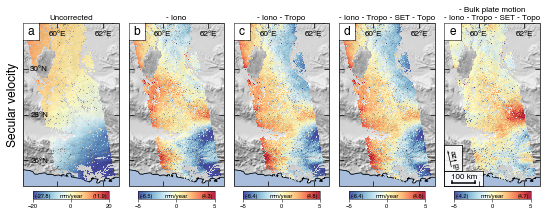

In [676]:
## Plot
dName = 'Makran a086'
name, track = dName.split(' ')

kwargs['vlims']      = [[-20 ,20], [-5,5], [-5,5], [-5,5], [-5,5]]
kwargs['annotation'] = ['a', 'b', 'c', 'd', 'e']

show_list = ['Uncorrected velocity', 'Ionosphere removed', 'Tropo model removed', 'SET & DEM error removed', 'Plate motion removed']
titles    = ['Uncorrected', '- Iono', '- Iono - Tropo', '- Iono - Tropo - SET - Topo', '- Bulk plate motion\n- Iono - Tropo - SET - Topo']
v_show    = {ikey: v[ikey] for ikey in show_list}
fname     = '{}/{}_{}_CorrSeries_0.png'.format(picdir, name, track)
plot_imgs(v_show, atr, demfile, titles=titles, super_title=None, row_title='Secular velocity', outfile=fname, **kwargs)

Plot data no. 1: <Ionosphere>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a086_velR.h5 velocity --fontsize 8 -u mm -v -20 20 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a086.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.05 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.8 --noreference
Plot data no. 2: <Troposphere>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a086_velR.h5 velocity --fontsize 8 -u mm -v -3 3 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a086.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.05 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.8 --noreference
Plot data no. 3: <SET>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a086_velR.h5 velocity --fonts

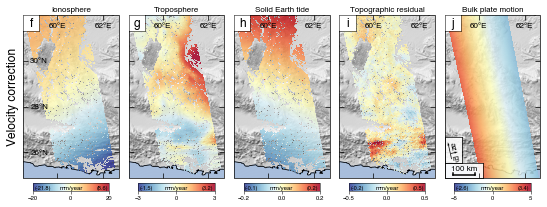

In [191]:
## Change the input data and color range to plot the correction

kwargs['vlims']      = [[-20 ,20], [-3,3], [-.2,.2], [-.5,.5], [-5,5]]
kwargs['annotation'] = ['f', 'g', 'h', 'i', 'j']

show_list = ['Ionosphere', 'Troposphere', 'SET', 'DEM error', 'Plate motion']
titles    = ['Ionosphere', 'Troposphere', 'Solid Earth tide', 'Topographic residual', 'Bulk plate motion']
v_show    = {ikey: v[ikey] for ikey in show_list}
fname     = '{}/{}_{}_CorrSeries_1.png'.format(picdir, name, track)
plot_imgs(v_show, atr, demfile, titles=titles, super_title=None, row_title='Velocity correction', outfile=fname, **kwargs)

In [678]:
vDict = {
            "geo"         : f"{datahome}/Makran_d020_Geo.h5",
            "dem"         : f"{datahome}/Makran_d020.dem",
            "velo_raw"    : f"{datahome}/Makran_d020_velR.h5",
            "velo_ion"    : f"{datahome}/Makran_d020_velR_ion.h5",
            "velo_ERA5"   : f"{datahome}/Makran_d020_velR_ion_ERA5.h5",
            "velo_SET"    : f"{datahome}/Makran_d020_velR_ion_ERA5_SET.h5",
            "velo_demErr" : f"{datahome}/Makran_d020_velR_ion_ERA5_SET_demErr.h5",
            "velo_bmModel": f"{datahome}/Makran_d020_vel_bmModel.h5",
            "velo_bmCorr" : f"{datahome}/Makran_d020_vel_bmCorr.h5"
            }

v, demfile, atr = prepare_data_order(vDict)

Plot data no. 1: <Uncorrected velocity>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020_velR.h5 velocity --fontsize 8 -u mm -v -6 6 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.05 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.8 --noreference
Plot data no. 2: <Ionosphere removed>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020_velR.h5 velocity --fontsize 8 -u mm -v -6 6 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.05 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.8 --noreference
Plot data no. 3: <Tropo model removed>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makra

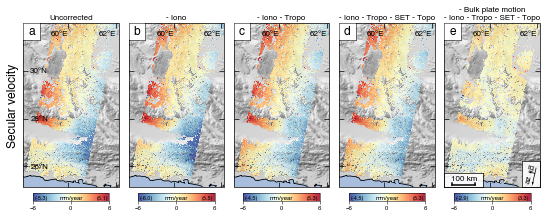

In [679]:
## Plot
dName = 'Makran d020'
name, track = dName.split(' ')

kwargs['sbox_loc']      = (0, 0, .4, .09)
kwargs['scalebar_loc']  = [0.3, kwargs['sbox_loc'][0]+0.2, kwargs['sbox_loc'][1]+.015]
kwargs['scalebar_pad']  = 0.04
kwargs['tbox_loc']      = (1-.19, 0, .19, .16)

kwargs['tick_params']= ['in', -14, -25, True, False, False, True, 'right', 'center']
kwargs['vlims']      = [-6,6]
kwargs['annotation'] = ['a', 'b', 'c', 'd', 'e']

show_list = ['Uncorrected velocity', 'Ionosphere removed', 'Tropo model removed', 'SET & DEM error removed', 'Plate motion removed']
titles    = ['Uncorrected', '- Iono', '- Iono - Tropo', '- Iono - Tropo - SET - Topo', '- Bulk plate motion\n- Iono - Tropo - SET - Topo']
v_show    = {ikey: v[ikey] for ikey in show_list}
fname     = '{}/{}_{}_CorrSeries_0.png'.format(picdir, name, track)
plot_imgs(v_show, atr, demfile, titles=titles, super_title=None, row_title='Secular velocity', outfile=fname, **kwargs)

Plot data no. 1: <Ionosphere>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020_velR.h5 velocity --fontsize 8 -u mm -v -2 2 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.05 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.8 --noreference
Plot data no. 2: <Troposphere>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020_velR.h5 velocity --fontsize 8 -u mm -v -2 2 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.05 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.8 --noreference
Plot data no. 3: <SET>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020_velR.h5 velocity --fontsiz

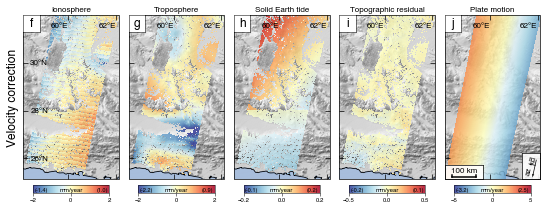

In [194]:
## Change the input data and color range to plot the correction

kwargs['vlims']      = [[-2,2], [-2,2], [-.2,.2], [-.5,.5], [-5,5]]
kwargs['annotation'] = ['f', 'g', 'h', 'i', 'j']

show_list = ['Ionosphere', 'Troposphere', 'SET', 'DEM error', 'Plate motion']
titles    = ['Ionosphere', 'Troposphere', 'Solid Earth tide', 'Topographic residual', 'Plate motion']
v_show    = {ikey: v[ikey] for ikey in show_list}
fname     = '{}/{}_{}_CorrSeries_1.png'.format(picdir, name, track)
plot_imgs(v_show, atr, demfile, titles=titles, super_title=None, row_title='Velocity correction', outfile=fname, **kwargs)

# Aqaba A087: ramp before and after plate motion correciton

In [195]:
datahome = '/net/kraken/nobak/ykliu/2022-BulkMotion/in_h5'
dName = 'Aqaba a087'
name, track = dName.split(' ')
vDict = {
            "geo"         : f"{datahome}/{name}_{track}_Geo.h5",
            "dem"         : f"{datahome}/{name}_{track}.dem",
            "velo_raw"    : f"{datahome}/{name}_{track}_velR.h5",
            "velo_ion"    : f"{datahome}/{name}_{track}_velR_ion.h5",
            "velo_ERA5"   : f"{datahome}/{name}_{track}_velR_ion_ERA5.h5",
            "velo_SET"    : f"{datahome}/{name}_{track}_velR_ion_ERA5_SET.h5",
            "velo_demErr" : f"{datahome}/{name}_{track}_velR_ion_ERA5_SET_demErr.h5",
            "velo_bmModel": f"{datahome}/{name}_{track}_velR_ion_ERA5_SET_demErr_bmModel.h5",
            "velo_bmCorr" : f"{datahome}/{name}_{track}_velR_ion_ERA5_SET_demErr_bmCorr.h5"
            }

v, demfile, atr = prepare_data_order(vDict)

Plot data no. 1: <Uncorrected velocity>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087_velR.h5 velocity --fontsize 8 -u mm -v -10 10 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.05 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.5 --noreference
Plot data no. 2: <Ionosphere removed>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087_velR.h5 velocity --fontsize 8 -u mm -v -10 10 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.05 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.5 --noreference
Plot data no. 3: <Tropo model removed>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba

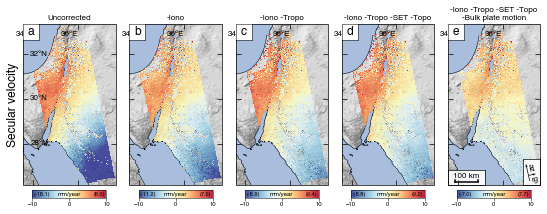

In [196]:
## Plot

kwargs['vlims']      = [[-10 ,10], [-10,10], [-10,10], [-10,10], [-10,10]]
kwargs['annotation'] = ['a', 'b', 'c', 'd', 'e']
kwargs['yticks'] = [28., 30., 32.]
kwargs['xticks'] = [34., 36.]
kwargs['coast_lw']   = 0.5

show_list = ['Uncorrected velocity', 'Ionosphere removed', 'Tropo model removed', 'SET & DEM error removed', 'Plate motion removed']
titles    = ['Uncorrected', '-Iono', '-Iono -Tropo', '-Iono -Tropo -SET -Topo', '-Iono -Tropo -SET -Topo\n-Bulk plate motion']
v_show    = {ikey: v[ikey] for ikey in show_list}
fname     = '{}/{}_{}_CorrSeries_0.png'.format(picdir, name, track)
plot_imgs(v_show, atr, demfile, titles=titles, super_title=None, row_title='Secular velocity', outfile=fname, **kwargs)

Plot data no. 1: <Ionosphere>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087_velR.h5 velocity --fontsize 8 -u mm -v -6 6 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.05 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.5 --noreference
Plot data no. 2: <Troposphere>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087_velR.h5 velocity --fontsize 8 -u mm -v -2 2 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.05 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.5 --noreference
Plot data no. 3: <SET>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087_velR.h5 velocity --fontsize 8 -

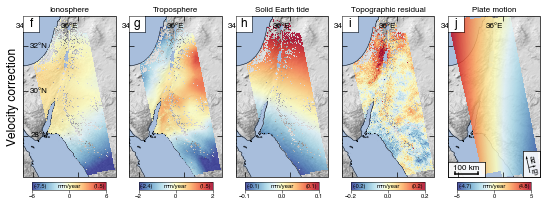

In [197]:
## Change the input data and color range to plot the correction

kwargs['vlims']      = [[-6,6], [-2,2], [-.1,.1], [-.2,.2], [-5,5]]
kwargs['annotation'] = ['f', 'g', 'h', 'i', 'j']

show_list = ['Ionosphere', 'Troposphere', 'SET', 'DEM error', 'Plate motion']
titles    = ['Ionosphere', 'Troposphere', 'Solid Earth tide', 'Topographic residual', 'Plate motion']
v_show    = {ikey: v[ikey] for ikey in show_list}
fname     = '{}/{}_{}_CorrSeries_1.png'.format(picdir, name, track)
plot_imgs(v_show, atr, demfile, titles=titles, super_title=None, row_title='Velocity correction', outfile=fname, **kwargs)

In [198]:
datahome = '/net/kraken/nobak/ykliu/2022-BulkMotion/in_h5'
dName = 'Aqaba d021'
name, track = dName.split(' ')
vDict = {
            "geo"         : f"{datahome}/{name}_{track}_Geo.h5",
            "dem"         : f"{datahome}/{name}_{track}.dem",
            "velo_raw"    : f"{datahome}/{name}_{track}_velR.h5",
            "velo_ion"    : f"{datahome}/{name}_{track}_velR_ion.h5",
            "velo_ERA5"   : f"{datahome}/{name}_{track}_velR_ion_ERA5.h5",
            "velo_SET"    : f"{datahome}/{name}_{track}_velR_ion_ERA5_SET.h5",
            "velo_demErr" : f"{datahome}/{name}_{track}_velR_ion_ERA5_SET_demErr.h5",
            "velo_bmModel": f"{datahome}/{name}_{track}_velR_ion_ERA5_SET_demErr_bmModel.h5",
            "velo_bmCorr" : f"{datahome}/{name}_{track}_velR_ion_ERA5_SET_demErr_bmCorr.h5"
            }

v, demfile, atr = prepare_data_order(vDict)

Plot data no. 1: <Uncorrected velocity>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021_velR.h5 velocity --fontsize 8 -u mm -v -6 6 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.05 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.5 --noreference
Plot data no. 2: <Ionosphere removed>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021_velR.h5 velocity --fontsize 8 -u mm -v -6 6 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.05 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.5 --noreference
Plot data no. 3: <Tropo model removed>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d02

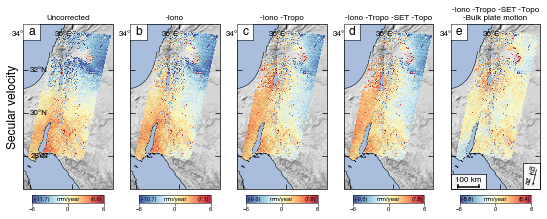

In [199]:
## Plot

kwargs['sbox_loc']      = (0, 0, .4, .09)
kwargs['scalebar_loc']  = [0.3, kwargs['sbox_loc'][0]+0.2, kwargs['sbox_loc'][1]+.015]
kwargs['scalebar_pad']  = 0.04
kwargs['tbox_loc']      = (1-.19, 0, .19, .16)
kwargs['vlims']      = [-6,6]
kwargs['annotation'] = ['a', 'b', 'c', 'd', 'e']
kwargs['coast_lw']   = 0.5

show_list = ['Uncorrected velocity', 'Ionosphere removed', 'Tropo model removed', 'SET & DEM error removed', 'Plate motion removed']
titles    = ['Uncorrected', '-Iono', '-Iono -Tropo', '-Iono -Tropo -SET -Topo', '-Iono -Tropo -SET -Topo\n-Bulk plate motion']
v_show    = {ikey: v[ikey] for ikey in show_list}
fname     = '{}/{}_{}_CorrSeries_0.png'.format(picdir, name, track)
plot_imgs(v_show, atr, demfile, titles=titles, super_title=None, row_title='Secular velocity', outfile=fname, **kwargs)

Plot data no. 1: <Ionosphere>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021_velR.h5 velocity --fontsize 8 -u mm -v -4 4 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.05 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.5 --noreference
Plot data no. 2: <Troposphere>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021_velR.h5 velocity --fontsize 8 -u mm -v -2 2 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.05 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.5 --noreference
Plot data no. 3: <SET>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021_velR.h5 velocity --fontsize 8 -

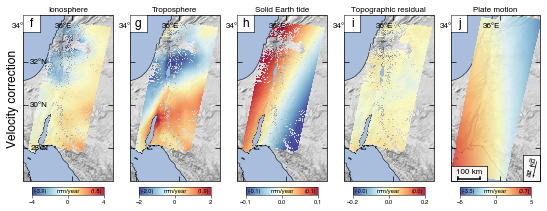

In [200]:
## Change the input data and color range to plot the correction

kwargs['vlims']      = [[-4,4], [-2,2], [-.1,.1], [-.2,.2], [-5,5]]
kwargs['annotation'] = ['f', 'g', 'h', 'i', 'j']

show_list = ['Ionosphere', 'Troposphere', 'SET', 'DEM error', 'Plate motion']
titles    = ['Ionosphere', 'Troposphere', 'Solid Earth tide', 'Topographic residual', 'Plate motion']
v_show    = {ikey: v[ikey] for ikey in show_list}
fname     = '{}/{}_{}_CorrSeries_1.png'.format(picdir, name, track)
plot_imgs(v_show, atr, demfile, titles=titles, super_title=None, row_title='Velocity correction', outfile=fname, **kwargs)

# Ramp profiles, before and after plate motion correction

In [430]:
## Again, read pre-defined paths
with open(my_json) as file:
    brief = json.load(file)

prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087_Geo.h5
Range ramp scatter plot shifted by median -2.9802322387695312e-08
Ground range min/max: 0.0 255.40157
Valid (non-nan pixels) ground range min/max: 0.929375 252.75
Ground range distance spans 251.8 km
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 255.40157
Valid (non-nan pixels) ground range min/max: 0.0 255.40157
Ground range distance spans 255.4 km
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 255.40157
Valid (non-nan pixels) ground range min/max: 0.929375 252.75
Ground range distance spans 251.8 km
Figure ext:png dpi:400 W/H:2992.125984251968/1196.8503937007872
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/Aqaba_a087_rampProf.png


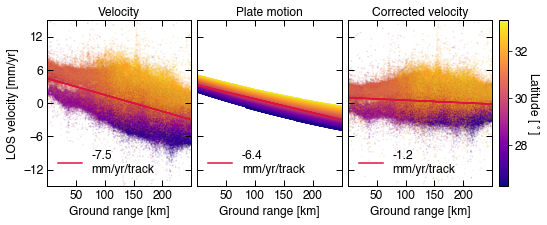

In [245]:
dName = 'Aqaba a087'
name, track = dName.split()
v, range_g, Lats, Lons, demfile, atr = prepare_data_bm(brief[dName])

# Initialize the kwargs
kwargs = dict()
kwargs['subplot_w']   = w_cm*cm2in
kwargs['cmap']        = 'plasma'
kwargs['vlim']        = [-15, 15]
kwargs['titstr']      = ['Velocity','Plate motion','Corrected velocity']
kwargs['title_pad']   = 4.
kwargs['range_type']  = 'Ground'
kwargs['alpha']       = 0.04

fn = f"{picdir}/{name}_{track}_rampProf.png"
plot_range_ramp(data1=v['Velocity2'], data2=v['Plate motion'], range_dist=range_g, latitude=Lats, super_title=None, outfile=fn, **kwargs)


prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087_Geo.h5
Plot data no. 1: <Velocity2>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087_vel.h5 velocity --fontsize 12 -u mm -v -10 10 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.8 --shade-exag 0.06 --shade-min -3000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.8 --noreference
Plot data no. 2: <Plate motion>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087_vel.h5 velocity --fontsize 12 -u mm -v -10 10 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.8 --shade-exag 0.06 --shade-min -3000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.8 --noreference


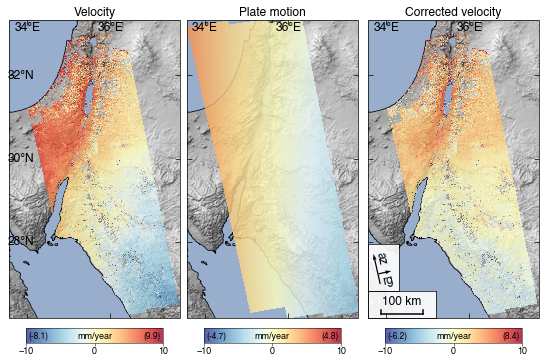

In [175]:
## Plot
dName = 'Aqaba a087'
name, track = dName.split()
v, range_g, Lats, Lons, demfile, atr = prepare_data_bm(brief[dName])


w_cm = 19       # max width of GRL figure
l_cm = 11.5     # not used
cm2in = 1/2.54  # mm to inches

kwargs = dict()
kwargs['subplot_w'] = w_cm*cm2in
kwargs['font_size'] = 12
kwargs['laloStep']  = 2
kwargs['wspace']    = 0.
kwargs['title_pad'] = 4
kwargs['suptity']   = 0.1
kwargs['alpha']     = 0.8
kwargs['shadeExg']  = 0.06
kwargs['shadeMin']  = -3e3
kwargs['shadeMax']  =  5e3
kwargs['refpoint']  = False
kwargs['dpi']       = 600
kwargs['cmap']      = 'RdYlBu_r'
kwargs['vlims']     = [-10,10]

kwargs['corient']       = 'horizontal'
kwargs['cbox_loc']      = (0., 0.-.125, 1, .1)
kwargs['cbox_hide']     = True
kwargs['clabel_pad']    = 0.4

kwargs['sbox_loc']      = (0, 0, .4, .09)
kwargs['scalebar_loc']  = [0.3, kwargs['sbox_loc'][0]+0.2, kwargs['sbox_loc'][1]+.015]
kwargs['scalebar_pad']  = 0.04

kwargs['tbox_loc']  = (0, kwargs['sbox_loc'][3], .18, .16)


v_show = v
fn = f"{picdir}/{name}_{track}_impactBM.png"
titles = ['Velocity', 'Plate motion', 'Corrected velocity']
plot_imgs(v_show, atr, demfile, titles=titles, super_title=None, outfile=fn, **kwargs)

prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087_Geo.h5
Plot data no. 1: <Velocity1>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087_vel.h5 velocity --fontsize 12 -u mm -v -12 12 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.8 --shade-exag 0.06 --shade-min -3000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.8 --noreference
Plot data no. 2: <VelocityIon>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087_vel.h5 velocity --fontsize 12 -u mm -v -12 12 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.8 --shade-exag 0.06 --shade-min -3000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.8 --noreference
P

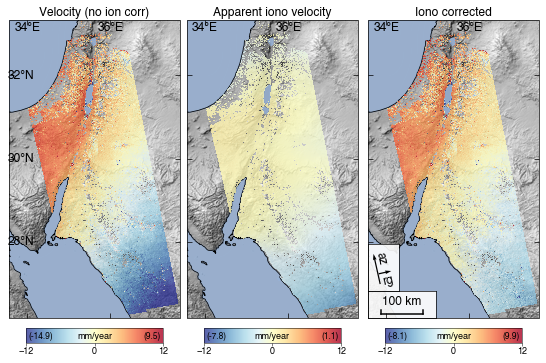

In [179]:
## Plot
dName = 'Aqaba a087'
name, track = dName.split()
v, range_g, Lats, Lons, demfile, atr = prepare_data_ion(brief[dName])

kwargs['vlims']     = [-12,12]

v_show = v
fn = f"{picdir}/{name}_{track}_impactION.png"
titles = ['Velocity (no ion corr)', 'Apparent iono velocity', 'Iono corrected']
plot_imgs(v_show, atr, demfile, titles=titles, super_title=None, outfile=fn, **kwargs)

prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021_Geo.h5
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.00183
Valid (non-nan pixels) ground range min/max: 1.7585938 254.00235
Ground range distance spans 252.2 km
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.00183
Valid (non-nan pixels) ground range min/max: 0.0 257.00183
Ground range distance spans 257.0 km
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.00183
Valid (non-nan pixels) ground range min/max: 1.7585938 254.00235
Ground range distance spans 252.2 km
Figure ext:png dpi:400 W/H:2992.125984251968/1196.8503937007872
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/Aqaba_d021_rampProf.png


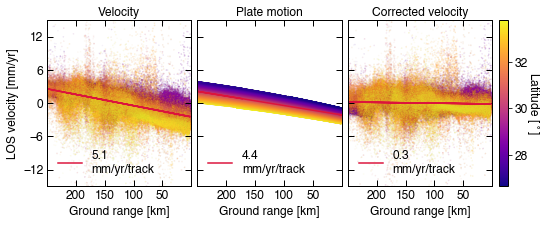

In [246]:
dName = 'Aqaba d021'
name, track = dName.split()
v, range_g, Lats, Lons, demfile, atr = prepare_data_bm(brief[dName])

# Initialize the kwargs
kwargs = dict()
kwargs['subplot_w']   = w_cm*cm2in
kwargs['cmap']        = 'plasma'
kwargs['vlim']        = [-15, 15]
kwargs['titstr']      = ['Velocity','Plate motion','Corrected velocity']
kwargs['title_pad']   = 4.
kwargs['range_type']  = 'Ground'
kwargs['alpha']       = 0.04

fn = f"{picdir}/{name}_{track}_rampProf.png"
plot_range_ramp(data1=v['Velocity2'], data2=v['Plate motion'], range_dist=range_g, latitude=Lats, super_title=None, outfile=fn, **kwargs)


prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021_Geo.h5
Plot data no. 1: <Velocity2>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021_vel.h5 velocity --fontsize 12 -u mm -v -10 10 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.8 --shade-exag 0.06 --shade-min -3000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.8 --noreference
Plot data no. 2: <Plate motion>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021_vel.h5 velocity --fontsize 12 -u mm -v -10 10 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.8 --shade-exag 0.06 --shade-min -3000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.8 --noreference


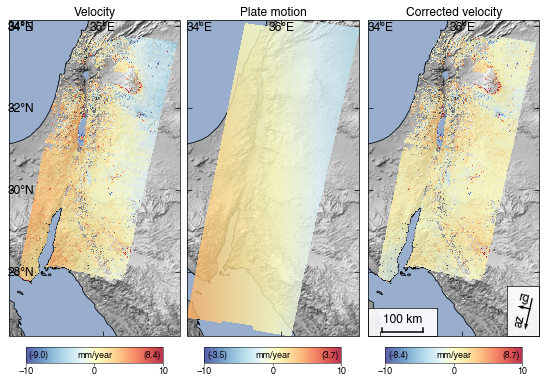

In [184]:
## Plot
dName = 'Aqaba d021'
name, track = dName.split()
v, range_g, Lats, Lons, demfile, atr = prepare_data_bm(brief[dName])

kwargs['vlims']     = [-10,10]

kwargs['sbox_loc']      = (0, 0, .4, .09)
kwargs['scalebar_loc']  = [0.3, kwargs['sbox_loc'][0]+0.2, kwargs['sbox_loc'][1]+.015]
kwargs['scalebar_pad']  = 0.04
kwargs['tbox_loc']      = (1-.19, 0, .19, .16)


v_show = v
fn = f"{picdir}/{name}_{track}_impactBM.png"
titles = ['Velocity', 'Plate motion', 'Corrected velocity']
plot_imgs(v_show, atr, demfile, titles=titles, super_title=None, outfile=fn, **kwargs)

prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021_Geo.h5
Plot data no. 1: <Velocity1>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021_vel.h5 velocity --fontsize 12 -u mm -v -6 6 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.8 --shade-exag 0.06 --shade-min -3000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.8 --noreference
Plot data no. 2: <VelocityIon>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021_vel.h5 velocity --fontsize 12 -u mm -v -6 6 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.8 --shade-exag 0.06 --shade-min -3000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.8 --noreference
Plot 

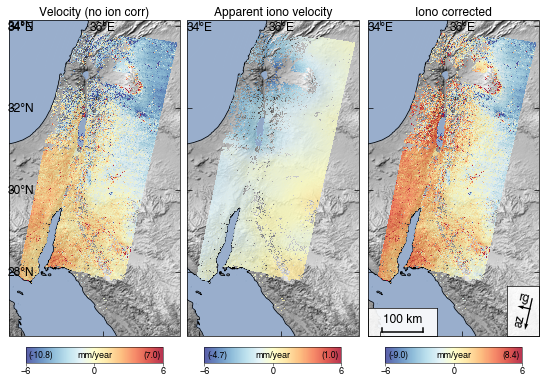

In [183]:
## Plot
dName = 'Aqaba d021'
name, track = dName.split()
v, range_g, Lats, Lons, demfile, atr = prepare_data_ion(brief[dName])

kwargs['vlims']     = [-6,6]

v_show = v
fn = f"{picdir}/{name}_{track}_impactION.png"
titles = ['Velocity (no ion corr)', 'Apparent iono velocity', 'Iono corrected']
plot_imgs(v_show, atr, demfile, titles=titles, super_title=None, outfile=fn, **kwargs)

prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a086_Geo.h5
Set weird modes to NaN: Velocity2
  Count: 1057 	 value: -1.2592207193374634
  Count: 252 	 value: -7.814444541931152


<ipython-input-428-a3a814cb7d4a>:477: RuntimeWarning: Mean of empty slice
  tmp = np.nanmean(xarry, axis=0)


Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.52603
Valid (non-nan pixels) ground range min/max: 0.7483125 257.50296
Ground range distance spans 256.8 km
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.52603
Valid (non-nan pixels) ground range min/max: 0.0 257.52603
Ground range distance spans 257.5 km
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.52603
Valid (non-nan pixels) ground range min/max: 0.7483125 257.50296
Ground range distance spans 256.8 km
Figure ext:png dpi:400 W/H:2992.125984251968/1196.8503937007872
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/Makran_a086_rampProf.png


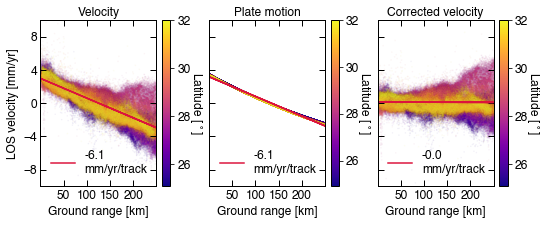

In [431]:
dName = 'Makran a086'
name, track = dName.split()
v, range_g, Lats, Lons, demfile, atr = prepare_data_bm(brief[dName])

for key in v:
    v[key] = remove_modes(v[key])

# Initialize the kwargs
w_cm = 19
kwargs = dict()
kwargs['subplot_w']   = w_cm*cm2in
kwargs['cmap']        = 'plasma'
kwargs['vlim']        = [-10,10]
kwargs['titstr']      = ['Velocity','Plate motion','Corrected velocity']
kwargs['title_pad']   = 4.
kwargs['range_type']  = 'Ground'
kwargs['alpha']       = 0.04

fn = f"{picdir}/{name}_{track}_rampProf.png"
plot_range_ramp(data1=v['Velocity2'], data2=v['Plate motion'], range_dist=range_g, latitude=Lats, super_title=None, outfile=fn, **kwargs)


prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020_Geo.h5
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.334
Valid (non-nan pixels) ground range min/max: 0.17575 256.69208
Ground range distance spans 256.5 km
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.334
Valid (non-nan pixels) ground range min/max: 0.0 257.334
Ground range distance spans 257.3 km
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.334
Valid (non-nan pixels) ground range min/max: 0.17575 256.69208
Ground range distance spans 256.5 km
Figure ext:png dpi:400 W/H:2992.125984251968/1196.8503937007872
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/Makran_d020_rampProf.png


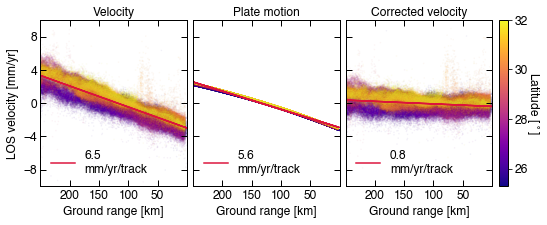

In [248]:
dName = 'Makran d020'
name, track = dName.split()
v, range_g, Lats, Lons, demfile, atr = prepare_data_bm(brief[dName])

for key in v:
    v[key] = remove_modes(v[key])

# Initialize the kwargs
kwargs = dict()
kwargs['subplot_w']   = w_cm*cm2in
kwargs['cmap']        = 'plasma'
kwargs['vlim']        = [-10,10]
kwargs['titstr']      = ['Velocity','Plate motion','Corrected velocity']
kwargs['title_pad']   = 4.
kwargs['range_type']  = 'Ground'
kwargs['alpha']       = 0.04

fn = f"{picdir}/{name}_{track}_rampProf.png"
plot_range_ramp(data1=v['Velocity2'], data2=v['Plate motion'], range_dist=range_g, latitude=Lats, super_title=None, outfile=fn, **kwargs)


prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a013_Geo.h5


<ipython-input-244-77532a113577>:471: RuntimeWarning: Mean of empty slice
  tmp = np.nanmean(range_dist, axis=0)


Range ramp scatter plot shifted by median 1.862645149230957e-09
Ground range min/max: 0.0 256.42004
Valid (non-nan pixels) ground range min/max: 0.306 256.42004
Ground range distance spans 256.1 km
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 256.42004
Valid (non-nan pixels) ground range min/max: 0.0 256.42004
Ground range distance spans 256.4 km
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 256.42004
Valid (non-nan pixels) ground range min/max: 0.306 256.42004
Ground range distance spans 256.1 km
Figure ext:png dpi:400 W/H:2992.125984251968/1196.8503937007872
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/Makran_a013_rampProf.png


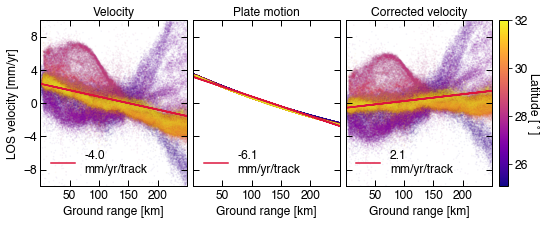

In [249]:
dName = 'Makran a013'
name, track = dName.split()
v, range_g, Lats, Lons, demfile, atr = prepare_data_bm(brief[dName])

for key in v:
    v[key] = remove_modes(v[key])

# Initialize the kwargs
kwargs = dict()
kwargs['subplot_w']   = w_cm*cm2in
kwargs['cmap']        = 'plasma'
kwargs['vlim']        = [-10,10]
kwargs['titstr']      = ['Velocity','Plate motion','Corrected velocity']
kwargs['title_pad']   = 4.
kwargs['range_type']  = 'Ground'
kwargs['alpha']       = 0.04

fn = f"{picdir}/{name}_{track}_rampProf.png"
plot_range_ramp(data1=v['Velocity2'], data2=v['Plate motion'], range_dist=range_g, latitude=Lats, super_title=None, outfile=fn, **kwargs)


prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a159_Geo.h5


<ipython-input-244-77532a113577>:471: RuntimeWarning: Mean of empty slice
  tmp = np.nanmean(range_dist, axis=0)


Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.86792
Valid (non-nan pixels) ground range min/max: 0.624875 257.28802
Ground range distance spans 256.7 km
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.86792
Valid (non-nan pixels) ground range min/max: 0.0 257.86792
Ground range distance spans 257.9 km
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.86792
Valid (non-nan pixels) ground range min/max: 0.624875 257.28802
Ground range distance spans 256.7 km
Figure ext:png dpi:400 W/H:2992.125984251968/1196.8503937007872
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/Makran_a159_rampProf.png


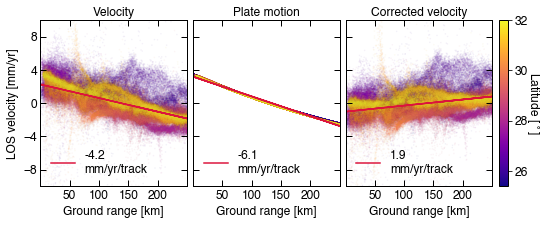

In [250]:
dName = 'Makran a159'
name, track = dName.split()
v, range_g, Lats, Lons, demfile, atr = prepare_data_bm(brief[dName])

for key in v:
    v[key] = remove_modes(v[key])

# Initialize the kwargs
kwargs = dict()
kwargs['subplot_w']   = w_cm*cm2in
kwargs['cmap']        = 'plasma'
kwargs['vlim']        = [-10,10]
kwargs['titstr']      = ['Velocity','Plate motion','Corrected velocity']
kwargs['title_pad']   = 4.
kwargs['range_type']  = 'Ground'
kwargs['alpha']       = 0.04

fn = f"{picdir}/{name}_{track}_rampProf.png"
plot_range_ramp(data1=v['Velocity2'], data2=v['Plate motion'], range_dist=range_g, latitude=Lats, super_title=None, outfile=fn, **kwargs)


prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a115_Geo.h5
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 255.4626
Valid (non-nan pixels) ground range min/max: 0.0455 253.6009
Ground range distance spans 253.6 km
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 255.4626
Valid (non-nan pixels) ground range min/max: 0.0 255.4626
Ground range distance spans 255.5 km
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 255.4626
Valid (non-nan pixels) ground range min/max: 0.0455 253.6009
Ground range distance spans 253.6 km
Figure ext:png dpi:400 W/H:2992.125984251968/1196.8503937007872
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/Makran_a115_rampProf.png


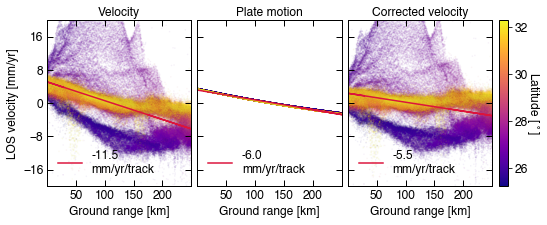

In [253]:
dName = 'Makran a115'
name, track = dName.split()
v, range_g, Lats, Lons, demfile, atr = prepare_data_bm(brief[dName])

for key in v:
    v[key] = remove_modes(v[key])

# Initialize the kwargs
kwargs = dict()
kwargs['subplot_w']   = w_cm*cm2in
kwargs['cmap']        = 'plasma'
kwargs['vlim']        = [-20,20]
kwargs['titstr']      = ['Velocity','Plate motion','Corrected velocity']
kwargs['title_pad']   = 4.
kwargs['range_type']  = 'Ground'
kwargs['alpha']       = 0.04

fn = f"{picdir}/{name}_{track}_rampProf.png"
plot_range_ramp(data1=v['Velocity2'], data2=v['Plate motion'], range_dist=range_g, latitude=Lats, super_title=None, outfile=fn, **kwargs)


prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Australia_d046_Geo.h5
Range ramp scatter plot shifted by median 1.4901161193847656e-08
Ground range min/max: 0.0 253.3031
Valid (non-nan pixels) ground range min/max: 0.1443125 251.93903
Ground range distance spans 251.8 km
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 253.3031
Valid (non-nan pixels) ground range min/max: 0.0 253.3031
Ground range distance spans 253.3 km
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 253.3031
Valid (non-nan pixels) ground range min/max: 0.1443125 251.93903
Ground range distance spans 251.8 km
Figure ext:png dpi:400 W/H:2992.125984251968/1196.8503937007872
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/Australia_d046_rampProf.png


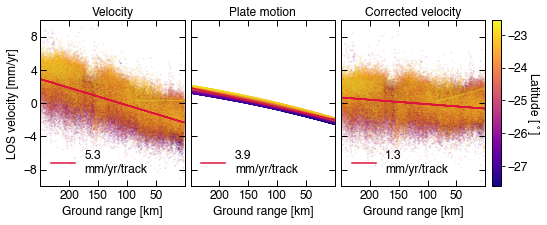

In [254]:
dName = 'Australia d046'
name, track = dName.split()
v, range_g, Lats, Lons, demfile, atr = prepare_data_bm(brief[dName])

# Initialize the kwargs
kwargs = dict()
kwargs['subplot_w']   = w_cm*cm2in
kwargs['cmap']        = 'plasma'
kwargs['vlim']        = [-10,10]
kwargs['titstr']      = ['Velocity','Plate motion','Corrected velocity']
kwargs['title_pad']   = 4.
kwargs['range_type']  = 'Ground'
kwargs['alpha']       = 0.04

fn = f"{picdir}/{name}_{track}_rampProf.png"
plot_range_ramp(data1=v['Velocity2'], data2=v['Plate motion'], range_dist=range_g, latitude=Lats, super_title=None, outfile=fn, **kwargs)


prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Australia_d119_Geo.h5
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 253.31784
Valid (non-nan pixels) ground range min/max: 0.9756875 251.99696
Ground range distance spans 251.0 km
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 253.31784
Valid (non-nan pixels) ground range min/max: 0.0 253.31784
Ground range distance spans 253.3 km
Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 253.31784
Valid (non-nan pixels) ground range min/max: 0.9756875 251.99696
Ground range distance spans 251.0 km
Figure ext:png dpi:400 W/H:2992.125984251968/1196.8503937007872
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/Australia_d119_rampProf.png


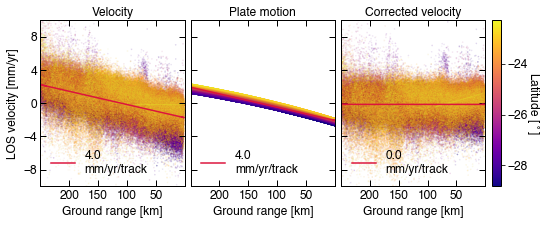

In [255]:
dName = 'Australia d119'
name, track = dName.split()
v, range_g, Lats, Lons, demfile, atr = prepare_data_bm(brief[dName])

# Initialize the kwargs
kwargs = dict()
kwargs['subplot_w']   = w_cm*cm2in
kwargs['cmap']        = 'plasma'
kwargs['vlim']        = [-10,10]
kwargs['titstr']      = ['Velocity','Plate motion','Corrected velocity']
kwargs['title_pad']   = 4.
kwargs['range_type']  = 'Ground'
kwargs['alpha']       = 0.04

fn = f"{picdir}/{name}_{track}_rampProf.png"
plot_range_ramp(data1=v['Velocity2'], data2=v['Plate motion'], range_dist=range_g, latitude=Lats, super_title=None, outfile=fn, **kwargs)


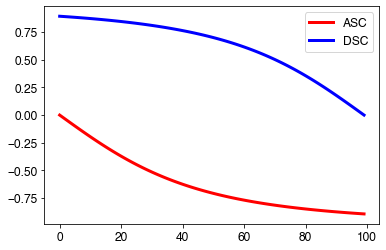

In [266]:
x = np.arange(100)
h = 50
theta_a = np.arctan(x/h)
theta_d = np.arctan((np.max(x)-x)/h)
vh = 1
vlos_a = -vh*np.sin(theta_a)
vlos_d = +vh*np.sin(theta_d)

plt.figure(figsize=[6,4])
plt.plot(x, vlos_a, c='r', lw=3, label='ASC')
plt.plot(x, vlos_d, c='b', lw=3, label='DSC')
plt.legend()
plt.show()

prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020_Geo.h5
Plot data no. 1: <Velocity2>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020_vel.h5 velocity --fontsize 12 -u mm -v -10 10 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.8 --shade-exag 0.06 --shade-min -3000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.8 --noreference
Plot data no. 2: <Plate motion>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020_vel.h5 velocity --fontsize 12 -u mm -v -10 10 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.8 --shade-exag 0.06 --shade-min -3000.0 --shade-max 5000.0 --lalo-step 2 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.8 --norefer

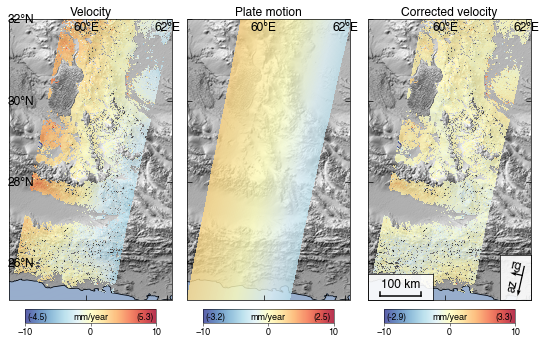

In [285]:
## Plot

dName = 'Makran d020'
name, track = dName.split()
v, range_g, Lats, Lons, demfile, atr = prepare_data_bm(brief[dName])


w_cm = 19      # max width of GRL figure
cm2in = 1/2.54  # mm to inches

kwargs = dict()
kwargs['subplot_w'] = w_cm*cm2in
kwargs['font_size'] = 12
kwargs['laloStep']  = 2
kwargs['wspace']    = 0.
kwargs['title_pad'] = 4
kwargs['suptity']   = 0.1
kwargs['alpha']     = 0.8
kwargs['shadeExg']  = 0.06
kwargs['shadeMin']  = -3e3
kwargs['shadeMax']  =  5e3
kwargs['refpoint']  = False
kwargs['dpi']       = 600
kwargs['cmap']      = 'RdYlBu_r'
kwargs['vlims']     = [-10,10]

kwargs['corient']       = 'horizontal'
kwargs['cbox_loc']      = (0., 0.-.125, 1, .1)
kwargs['cbox_hide']     = True
kwargs['clabel_pad']    = 0.4

kwargs['sbox_loc']      = (0, 0, .4, .09)
kwargs['scalebar_loc']  = [0.3, kwargs['sbox_loc'][0]+0.2, kwargs['sbox_loc'][1]+.015]
kwargs['scalebar_pad']  = 0.04
kwargs['tbox_loc']      = (1-.19, 0, .19, .16)


show_list = ['Velocity2']
v_show    = v # {ikey: v[ikey] for ikey in show_list}
fn = f"{picdir}/{name}_{track}_impactBM.png"
titles = ['Velocity', 'Plate motion', 'Corrected velocity']
plot_imgs(v_show, atr, demfile, titles=titles, super_title=None, outfile=fn, **kwargs)

# Figure 3

In [657]:
def plot_rampprof(data1, data2=None, range_dist=None, latitude=None, super_title=None, plot=True, outfile=False, **kwargs):
    # Initialize the kwargs  
    if 'subplot_w'  not in kwargs.keys():   kwargs['subplot_w']   = 7.
    if 'subplot_h'  not in kwargs.keys():   kwargs['subplot_h']   = 7.
    if 'cmap'       not in kwargs.keys():   kwargs['cmap']        = 'plasma'
    if 'alpha'      not in kwargs.keys():   kwargs['alpha']       = 0.5
    if 'vlim'       not in kwargs.keys():   kwargs['vlim']        = [None,None]
    if 'clim'       not in kwargs.keys():   kwargs['clim']        = [None,None]    
    if 'titstr'     not in kwargs.keys():   kwargs['titstr']      = ''
    if 'title_pad'  not in kwargs.keys():   kwargs['title_pad']   = 5.
    if 'range_type' not in kwargs.keys():   kwargs['range_type']  = None
    if 'slope_norm' not in kwargs.keys():   kwargs['slope_norm']  = 'L2'
    if 'flipud'     not in kwargs.keys():   kwargs['flipud']      = True
    if 'fliplr_auto'not in kwargs.keys():   kwargs['fliplr_auto'] = True
    if 'ticks'      not in kwargs.keys():   kwargs['ticks']       = True
    if 'dpi'        not in kwargs.keys():   kwargs['dpi']         = 1200
    if 'font_size'  not in kwargs.keys():   kwargs['font_size']   = 12
    if 'tick_params'not in kwargs.keys():   kwargs['tick_params'] = ['in', -14, -14, 
                                                                       True, False, False, True, 
                                                                       'center', 'center']

    
    # compare different inputs
    if data2 is not None:
        overlay = True
    else:
        overlay = False

    # get range and azimuth bins
    length, width = data1.shape
    rbins = np.tile(np.arange(width), (length, 1))
    abins = np.tile(np.arange(length), (width, 1)).T

    # range_bin, groundRangeDistance, or slantRangeDistance for x-axis
    if range_dist is None:
        xarry      = np.array(rbins)
        yarry      = np.array(abins)
        xlabel     = 'Range bin'
        ylabel     = 'Azimuth bin'
        slope_unit = 'mm/yr/track'
        factor     = float(width)
    else:
        xarry      = np.array(range_dist)
        xlabel     = '{} range [km]'.format(kwargs['range_type'].title())
        slope_unit = 'mm/yr/km'
        factor     = 1.0
        if latitude is None:
            yarry  = np.array(abins)
            ylabel = 'Azimuth bin'
        else:
            yarry  = np.array(latitude)
            ylabel = r'Latitude [$^\circ$]'

    # flip all arrays up-down (scatter plot the points at larger y-axis first)
    if kwargs['flipud']:
        xarry = np.flipud(xarry)
        yarry = np.flipud(yarry)
        data1 = np.flipud(data1)
        if data2:
            data2 = np.flipud(data2)

    # flip all arrays left-right (descending range flip to align with rough East-West)
    if kwargs['fliplr_auto']:
        tmp = np.nanmean(xarry, axis=0)
        if tmp[0] > tmp[-1]:
            xlim = [250,0]
            xticks = np.flip(np.arange(50,250,50))
            ytick_loc = 'right'
        else:
            xlim = [0,250]
            xticks = np.arange(50,250,50)
            ytick_loc = 'left'            
            
    # Plot single scatter plot
    # Set the figure
    fig, ax = plt.subplots(figsize=[kwargs['subplot_w'], kwargs['subplot_h']], ncols=1, sharey=True)
    x = xarry.flatten()[~np.isnan(data1.flatten())]
    y = data1.flatten()[~np.isnan(data1.flatten())]
    c = yarry.flatten()[~np.isnan(data1.flatten())]
    y = y - np.nanmedian(y)        

    print('Range ramp scatter plot shifted by median {}'.format(np.nanmedian(y)))
    print('Ground range min/max:', np.nanmin(xarry), np.nanmax(xarry))
    print('Valid (non-nan pixels) ground range min/max:', np.nanmin(x), np.nanmax(x))

    # linear fit to the trend
    if kwargs['slope_norm'] == 'L2':
        fit, y_pred  = scipy_L2_reg(x, y)
        params_legend = 'y=ax+b, a={:.3f} ± {:.2e}\n'.format(fit[0], fit.stderr)
    elif kwargs['slope_norm'] == 'L1':
        fit, y_pred  = cvxpy_reg(x, y, p=1)
        params_legend = 'y=ax+b, a={:.3f}\n'.format(fit[0])

    if range_dist is None:
        params_legend += 'slope = {:.3f} {:s}'.format(fit[0]*factor, slope_unit)
    else:
        range_span = np.max(x) - np.min(x)
        print('{} range distance spans {:.1f} km'.format(kwargs['range_type'].title(), range_span))
        params_legend += 'slope = {:.3f} {:s}'.format(fit[0]*factor, slope_unit)
        show_legend    = '{:.1f}\nmm/yr/track'.format(fit[0]*range_span)
        params_legend += '\n'+show_legend

    #sc = ax.scatter(x, y, s=0.5, c=c, cmap=kwargs['cmap'], alpha=kwargs['alpha'])
    sc = ax.scatter(x, y, s=5, c=c, marker='.', vmin=kwargs['clim'][0], vmax=kwargs['clim'][1],
                    edgecolors='none', cmap=kwargs['cmap'], alpha=kwargs['alpha'])
    ax.set_title(kwargs['titstr'], fontsize=kwargs['font_size'], pad=kwargs['title_pad'])
    ax.set_ylim(kwargs['vlim'][0], kwargs['vlim'][1])
    ax.set_xticks([100,200])
    ax.xaxis.set_tick_params(labelsize=kwargs['font_size'])
    ax.yaxis.set_tick_params(labelsize=kwargs['font_size'])
    ax.yaxis.set_major_locator(MaxNLocator(3))
    ax.tick_params(direction='in', length=5, width=.7, colors='k', top=True, right=True)
    tdir, xpad, ypad, l, r, b, t, xha, yha = kwargs['tick_params']
    ax.tick_params(axis="x", direction=tdir, pad=xpad, labelleft=l, labelright=r, labelbottom=b, labeltop=t)
    ax.tick_params(axis="y", direction=tdir, pad=ypad, labelleft=l, labelright=r, labelbottom=b, labeltop=t)
    for lab in ax.xaxis.get_ticklabels(): lab.set_horizontalalignment(xha)        
    for lab in ax.yaxis.get_ticklabels(): lab.set_horizontalalignment(yha)    
    if kwargs['ticks'] is False:
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])

    ax.set_xlim(xlim)
    [sp.set_linewidth(.7) for sp in ax.spines.values()]
    [sp.set_zorder(10)    for sp in ax.spines.values()]

    # Save figure
    if outfile:
        save_fig(fig, outfile, dpi=kwargs['dpi'])

    plt.show()


def plot_insetprofs(dName, brief, w_cm, kwargs):
    name, track = dName.split()
    v, range_g, Lats, Lons, demfile, atr = prepare_data_bm(brief[dName])
    
    if track.startswith('a'):
        tmp1 = ['in', -12, -8, True, False, True, False, 'center', 'left']
        tmp2 = ['in', -12, -8, False, False, True, False, 'center', 'center']
    elif track.startswith('d'):
        tmp1 = ['in', -12, -8, False, False, True, False, 'center', 'center']
        tmp2 = ['in', -12, -8, False, True, True, False, 'center', 'right']
    tmp3 = ['in', -12, -8, False, False, False, False, 'center', 'center']    
    
    for key in v:
        v[key] = remove_modes(v[key], N=10)
    v['Corrected velocity'] = v['Velocity2']-v['Plate motion']
    
    lat_min = np.nanmin(Lats)
    lat_max = np.nanmax(Lats)
    print('Latitude: {:.2f} / {:.2f}'.format(lat_min, lat_max))
    symbol_cbar_lat(vlim=[str(int(lat_min)), str(int(lat_max))], font_size=10, name='_'+track)
    kwargs['clim']      = [lat_min, lat_max]
    
    #-------- before
    kwargs['subplot_w'] = w_cm*cm2in
    kwargs['subplot_h'] = w_cm*cm2in * .7
    kwargs['titstr']    = ''
    kwargs['ticks']     = True
    kwargs['tick_params'] = tmp1
    fn = f"{picdir}/insets/{name}_{track}_rb.png"
    plot_rampprof(data1=v['Velocity2'], data2=None, range_dist=range_g, latitude=Lats, super_title=None, outfile=fn, **kwargs)

    #-------- after
    kwargs['subplot_w'] = w_cm*cm2in
    kwargs['subplot_h'] = w_cm*cm2in * .7    
    kwargs['titstr']    = ''
    kwargs['ticks']     = True
    kwargs['tick_params'] = tmp2    
    fn = f"{picdir}/insets/{name}_{track}_ra.png"
    plot_rampprof(data1=v['Corrected velocity'], data2=None, range_dist=range_g, latitude=Lats, super_title=None, outfile=fn, **kwargs)

    #-------- PMM
    kwargs['subplot_w'] = w_cm*cm2in / 2.4
    kwargs['subplot_h'] = w_cm*cm2in / 2.4
    kwargs['titstr']    = ''
    kwargs['ticks']     = False
    kwargs['tick_params'] = tmp3    
    fn = f"{picdir}/insets/{name}_{track}_rm.png"
    plot_rampprof(data1=v['Plate motion'], data2=None, range_dist=range_g, latitude=Lats, super_title=None, outfile=fn, **kwargs)        

prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a086_Geo.h5
Latitude: 24.89 / 32.00
save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/cbar_lat_a086.pdf


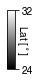

Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.52603
Valid (non-nan pixels) ground range min/max: 0.7483125 257.50296
Ground range distance spans 256.8 km
Figure ext:png dpi:1200 W/H:1984.25/1388.98
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Makran_a086_rb.png


<ipython-input-657-ec7d87c2fe75>:64: RuntimeWarning: Mean of empty slice
  tmp = np.nanmean(xarry, axis=0)


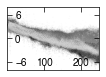

Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.52603
Valid (non-nan pixels) ground range min/max: 0.7483125 257.50296
Ground range distance spans 256.8 km
Figure ext:png dpi:1200 W/H:1984.25/1388.98
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Makran_a086_ra.png


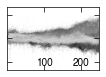

Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.52603
Valid (non-nan pixels) ground range min/max: 0.0 257.52603
Ground range distance spans 257.5 km
Figure ext:png dpi:1200 W/H:826.77/826.77
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Makran_a086_rm.png


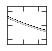

prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020_Geo.h5
Latitude: 25.10 / 32.00
save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/cbar_lat_d020.pdf


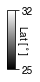

Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.334
Valid (non-nan pixels) ground range min/max: 0.17575 256.69208
Ground range distance spans 256.5 km
Figure ext:png dpi:1200 W/H:1984.25/1388.98
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Makran_d020_rb.png


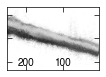

Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.334
Valid (non-nan pixels) ground range min/max: 0.17575 256.69208
Ground range distance spans 256.5 km
Figure ext:png dpi:1200 W/H:1984.25/1388.98
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Makran_d020_ra.png


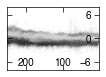

Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.334
Valid (non-nan pixels) ground range min/max: 0.0 257.334
Ground range distance spans 257.3 km
Figure ext:png dpi:1200 W/H:826.77/826.77
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Makran_d020_rm.png


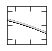

prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087_Geo.h5
Latitude: 26.17 / 33.33
save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/cbar_lat_a087.pdf


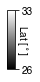

Range ramp scatter plot shifted by median -2.9802322387695312e-08
Ground range min/max: 0.0 255.40157
Valid (non-nan pixels) ground range min/max: 0.929375 252.75
Ground range distance spans 251.8 km
Figure ext:png dpi:1200 W/H:1984.25/1388.98
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Aqaba_a087_rb.png


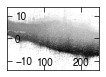

Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 255.40157
Valid (non-nan pixels) ground range min/max: 0.929375 252.75
Ground range distance spans 251.8 km
Figure ext:png dpi:1200 W/H:1984.25/1388.98
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Aqaba_a087_ra.png


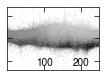

Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 255.40157
Valid (non-nan pixels) ground range min/max: 0.0 255.40157
Ground range distance spans 255.4 km
Figure ext:png dpi:1200 W/H:826.77/826.77
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Aqaba_a087_rm.png


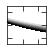

prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021_Geo.h5
Latitude: 26.43 / 34.17
save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/cbar_lat_d021.pdf


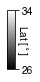

Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.00183
Valid (non-nan pixels) ground range min/max: 1.7585938 254.00235
Ground range distance spans 252.2 km
Figure ext:png dpi:1200 W/H:1984.25/1388.98
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Aqaba_d021_rb.png


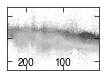

Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.00183
Valid (non-nan pixels) ground range min/max: 1.7585938 254.00235
Ground range distance spans 252.2 km
Figure ext:png dpi:1200 W/H:1984.25/1388.98
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Aqaba_d021_ra.png


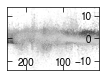

Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 257.00183
Valid (non-nan pixels) ground range min/max: 0.0 257.00183
Ground range distance spans 257.0 km
Figure ext:png dpi:1200 W/H:826.77/826.77
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Aqaba_d021_rm.png


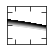

prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Australia_d046_Geo.h5
Latitude: -27.63 / -22.53
save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/cbar_lat_d046.pdf


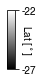

Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 253.3031
Valid (non-nan pixels) ground range min/max: 1.0349687 251.34735
Ground range distance spans 250.3 km
Figure ext:png dpi:1200 W/H:1984.25/1388.98
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Australia_d046_rb.png


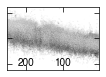

Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 253.3031
Valid (non-nan pixels) ground range min/max: 1.0349687 251.34735
Ground range distance spans 250.3 km
Figure ext:png dpi:1200 W/H:1984.25/1388.98
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Australia_d046_ra.png


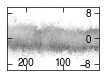

Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 253.3031
Valid (non-nan pixels) ground range min/max: 0.0 253.3031
Ground range distance spans 253.3 km
Figure ext:png dpi:1200 W/H:826.77/826.77
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Australia_d046_rm.png


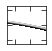

prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Australia_d119_Geo.h5
Latitude: -28.83 / -22.24
save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/cbar_lat_d119.pdf


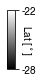

Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 253.31784
Valid (non-nan pixels) ground range min/max: 1.0149063 251.99696
Ground range distance spans 251.0 km
Figure ext:png dpi:1200 W/H:1984.25/1388.98
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Australia_d119_rb.png


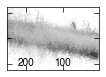

Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 253.31784
Valid (non-nan pixels) ground range min/max: 1.0149063 251.99696
Ground range distance spans 251.0 km
Figure ext:png dpi:1200 W/H:1984.25/1388.98
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Australia_d119_ra.png


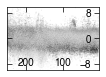

Range ramp scatter plot shifted by median 0.0
Ground range min/max: 0.0 253.31784
Valid (non-nan pixels) ground range min/max: 0.0 253.31784
Ground range distance spans 253.3 km
Figure ext:png dpi:1200 W/H:826.77/826.77
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Australia_d119_rm.png


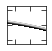

In [669]:
w_cm = 4.2   # max width of GRL figure
cm2in = 1/2.54  # mm to inches

# Initialize the kwargs
kwargs = dict()
kwargs['cmap']        = 'gray'
kwargs['title_pad']   = 4.
kwargs['range_type']  = 'Ground'
kwargs['alpha']       = 0.04
kwargs['dpi']         = 1200
kwargs['font_size']   = 10

dName = 'Makran a086'
kwargs['vlim']        = [-8,8]
plot_insetprofs(dName, brief, w_cm, kwargs)

dName = 'Makran d020'
kwargs['vlim']        = [-8,8]
plot_insetprofs(dName, brief, w_cm, kwargs)

dName = 'Aqaba a087'
kwargs['vlim']        = [-14,14]
plot_insetprofs(dName, brief, w_cm, kwargs)

dName = 'Aqaba d021'
kwargs['vlim']        = [-14,14]
plot_insetprofs(dName, brief, w_cm, kwargs)

dName = 'Australia d046'
kwargs['vlim']        = [-10,10]
plot_insetprofs(dName, brief, w_cm, kwargs)

dName = 'Australia d119'
kwargs['vlim']        = [-10,10]
plot_insetprofs(dName, brief, w_cm, kwargs)

In [667]:
w_cm = 3.5      # max width of GRL figure
cm2in = 1/2.54  # mm to inches

kwargs = dict()
kwargs['subplot_w'] = w_cm*cm2in
kwargs['font_size'] = 10
kwargs['laloStep']  = 4
kwargs['title_pad'] = 4
kwargs['suptity']   = 0.1
kwargs['alpha']     = 0.85
kwargs['shadeExg']  = 0.06
kwargs['shadeMin']  = -5e3
kwargs['shadeMax']  =  5e3
kwargs['refpoint']  = False
kwargs['dpi']       = 800
kwargs['cmap']      = 'RdYlBu_r'
kwargs['vlims']     = [-8,8]

kwargs['cbox_loc']  = False
kwargs['sbox_loc']  = False
kwargs['tbox_loc']  = False

kwargs['coast_lw'] = 0.3


def make_insetmaps(dName, brief, w_cm, kwargs):
    name, track = dName.split()
    v, range_g, Lats, Lons, demfile, atr = prepare_data_bm(brief[dName])
    
    if track.startswith('a') or track.startswith('d046'):
        tmp1 = ['in', -15, -35, True, False, True, False, 'center', 'center']
        tmp2 = ['in', -15, -35, False, False, True, False, 'center', 'center']
    elif track.startswith('d'):
        if track.startswith('d119'):
            tmp1 = ['in', -15, -35, False, False, True, False, 'right', 'center']
            tmp2 = ['in', -15, -35, False, True, True, False, 'right', 'center']
        else:
            tmp1 = ['in', -15, -35, False, False, True, False, 'center', 'center']
            tmp2 = ['in', -15, -35, False, True, True, False, 'center', 'center']
    tmp3 = ['in', -15, -35, False, False, False, False, 'center', 'center']
        
    #-------- before
    kwargs['tick_params'] = tmp1
    kwargs['subplot_w'] = w_cm*cm2in
    show_list = ['Velocity2']
    titles    = False
    f_suff    = 'vb'
    v_show    = {ikey: v[ikey] for ikey in show_list}
    fn = f"{picdir}/insets/{name}_{track}_{f_suff}.png"
    plot_imgs(v_show, atr, demfile, titles=titles, super_title=None, outfile=fn, **kwargs)


    #-------- after
    kwargs['tick_params'] = tmp2
    kwargs['subplot_w'] = w_cm*cm2in
    show_list = ['Corrected velocity']
    titles    = False
    f_suff    = 'va'
    v_show    = {ikey: v[ikey] for ikey in show_list}
    fn = f"{picdir}/insets/{name}_{track}_{f_suff}.png"
    plot_imgs(v_show, atr, demfile, titles=titles, super_title=None, outfile=fn, **kwargs)


    #-------- PMM
    kwargs['tick_params'] = tmp3
    kwargs['subplot_w'] = w_cm*cm2in/2.3 
    show_list = ['Plate motion']
    titles    = False
    f_suff    = 'vm'
    v_show    = {ikey: v[ikey] for ikey in show_list}
    fn = f"{picdir}/insets/{name}_{track}_{f_suff}.png"
    plot_imgs(v_show, atr, demfile, titles=titles, super_title=None, outfile=fn, **kwargs)    

prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a086_Geo.h5
Plot data no. 1: <Velocity2>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a086_vel.h5 velocity --fontsize 10 -u mm -v -8 8 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a086.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.06 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 4 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.3 --noreference
Figure ext:png dpi:800 W/H:1102.36/2804.12
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Makran_a086_vb.png


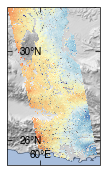

Plot data no. 1: <Corrected velocity>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a086_vel.h5 velocity --fontsize 10 -u mm -v -8 8 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a086.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.06 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 4 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.3 --noreference
Figure ext:png dpi:800 W/H:1102.36/2804.12
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Makran_a086_va.png


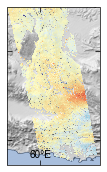

Plot data no. 1: <Plate motion>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a086_vel.h5 velocity --fontsize 10 -u mm -v -8 8 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_a086.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.06 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 4 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.3 --noreference
Figure ext:png dpi:800 W/H:479.29/1219.18
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Makran_a086_vm.png


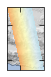

prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020_Geo.h5
Plot data no. 1: <Velocity2>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020_vel.h5 velocity --fontsize 10 -u mm -v -8 8 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.06 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 4 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.3 --noreference
Figure ext:png dpi:800 W/H:1102.36/2834.65
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Makran_d020_vb.png


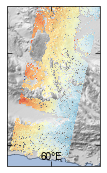

Plot data no. 1: <Corrected velocity>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020_vel.h5 velocity --fontsize 10 -u mm -v -8 8 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.06 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 4 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.3 --noreference
Figure ext:png dpi:800 W/H:1102.36/2834.65
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Makran_d020_va.png


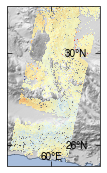

Plot data no. 1: <Plate motion>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020_vel.h5 velocity --fontsize 10 -u mm -v -8 8 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Makran_d020.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.06 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 4 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.3 --noreference
Figure ext:png dpi:800 W/H:479.29/1232.45
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Makran_d020_vm.png


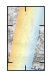

prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087_Geo.h5
Plot data no. 1: <Velocity2>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087_vel.h5 velocity --fontsize 10 -u mm -v -8 8 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.06 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 4 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.3 --noreference
Figure ext:png dpi:800 W/H:1102.36/2872.82
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Aqaba_a087_vb.png


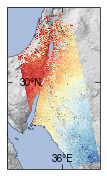

Plot data no. 1: <Corrected velocity>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087_vel.h5 velocity --fontsize 10 -u mm -v -8 8 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.06 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 4 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.3 --noreference
Figure ext:png dpi:800 W/H:1102.36/2872.82
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Aqaba_a087_va.png


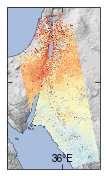

Plot data no. 1: <Plate motion>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087_vel.h5 velocity --fontsize 10 -u mm -v -8 8 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_a087.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.06 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 4 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.3 --noreference
Figure ext:png dpi:800 W/H:479.29/1249.05
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Aqaba_a087_vm.png


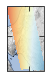

prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021_Geo.h5
Plot data no. 1: <Velocity2>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021_vel.h5 velocity --fontsize 10 -u mm -v -8 8 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.06 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 4 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.3 --noreference
Figure ext:png dpi:800 W/H:1102.36/3056.49
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Aqaba_d021_vb.png


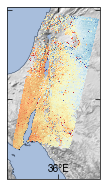

Plot data no. 1: <Corrected velocity>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021_vel.h5 velocity --fontsize 10 -u mm -v -8 8 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.06 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 4 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.3 --noreference
Figure ext:png dpi:800 W/H:1102.36/3056.49
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Aqaba_d021_va.png


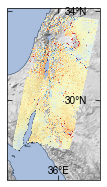

Plot data no. 1: <Plate motion>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021_vel.h5 velocity --fontsize 10 -u mm -v -8 8 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Aqaba_d021.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.06 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 4 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.3 --noreference
Figure ext:png dpi:800 W/H:479.29/1328.91
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Aqaba_d021_vm.png


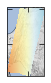

prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Australia_d046_Geo.h5
Plot data no. 1: <Velocity2>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Australia_d046_vel.h5 velocity --fontsize 10 -u mm -v -8 8 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Australia_d046.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.06 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 4 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.3 --noreference
Figure ext:png dpi:800 W/H:1102.36/2260.80
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Australia_d046_vb.png


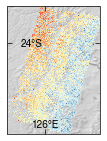

Plot data no. 1: <Corrected velocity>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Australia_d046_vel.h5 velocity --fontsize 10 -u mm -v -8 8 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Australia_d046.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.06 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 4 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.3 --noreference
Figure ext:png dpi:800 W/H:1102.36/2260.80
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Australia_d046_va.png


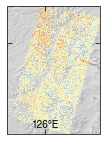

Plot data no. 1: <Plate motion>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Australia_d046_vel.h5 velocity --fontsize 10 -u mm -v -8 8 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Australia_d046.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.06 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 4 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.3 --noreference
Figure ext:png dpi:800 W/H:479.29/982.96
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Australia_d046_vm.png


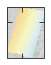

prepare range distance in geo-coordinates from file: /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Australia_d119_Geo.h5
Plot data no. 1: <Velocity2>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Australia_d119_vel.h5 velocity --fontsize 10 -u mm -v -8 8 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Australia_d119.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.06 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 4 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.3 --noreference
Figure ext:png dpi:800 W/H:1102.36/2608.64
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Australia_d119_vb.png


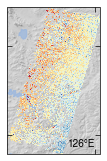

Plot data no. 1: <Corrected velocity>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Australia_d119_vel.h5 velocity --fontsize 10 -u mm -v -8 8 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Australia_d119.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.06 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 4 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.3 --noreference
Figure ext:png dpi:800 W/H:1102.36/2608.64
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Australia_d119_va.png


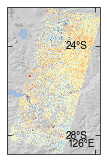

Plot data no. 1: <Plate motion>
view.py /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Australia_d119_vel.h5 velocity --fontsize 10 -u mm -v -8 8 --mask no --dem /net/kraken/nobak/ykliu/2022-BulkMotion/in_h5/Australia_d119.dem --dem-nocontour -c RdYlBu_r --nocbar --alpha 0.85 --shade-exag 0.06 --shade-min -5000.0 --shade-max 5000.0 --lalo-step 4 --lalo-loc 1 0 0 1 --noscalebar --notitle --noverbose --coastline 10m --coastline-lw 0.3 --noreference
Figure ext:png dpi:800 W/H:479.29/1134.19
Save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/Australia_d119_vm.png


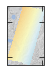

In [668]:
dName = 'Makran a086'
make_insetmaps(dName, brief, w_cm, kwargs)

dName = 'Makran d020'
make_insetmaps(dName, brief, w_cm, kwargs)

dName = 'Aqaba a087'
make_insetmaps(dName, brief, w_cm, kwargs)

dName = 'Aqaba d021'
make_insetmaps(dName, brief, w_cm, kwargs)

dName = 'Australia d046'
make_insetmaps(dName, brief, w_cm, kwargs)

dName = 'Australia d119'
make_insetmaps(dName, brief, w_cm, kwargs)

In [663]:
import matplotlib as mpl



def symbol_cbar_velo(vlim=['-10', '10'], font_size=10, name=''):
    # Fig 3 velocity map colormap (mm/yr)
    fig = plt.figure(figsize=(0.12, .9))
    ax  = fig.add_axes([0.05, 0.05, 0.9, 0.9])
    cbar = mpl.colorbar.ColorbarBase(ax, cmap=plt.get_cmap('RdYlBu_r'), orientation='vertical', ticks=[0, 1], extend='neither')
    cbar.ax.set_yticklabels(vlim)
    cbar.ax.tick_params(which='both', direction='out', labelsize=font_size)
    cbar.set_label('[mm/yr]', fontsize=font_size, labelpad=-4, rotation=270)
    #ax.text(0.5,1.5, 'LOS velocity', ha='center')
    fn = f"{picdir}/insets/cbar_velo{name}.pdf"
    plt.savefig(fn, bbox_inches='tight', transparent=True, dpi=800)
    print('save to file: '+fn)
    plt.show()

def symbol_cbar_lat(vlim=['25', '32'], font_size=10, name=''):
    # Fig 3 velocity profile colormap (latitude deg)
    fig = plt.figure(figsize=(0.12, .9))
    ax  = fig.add_axes([0.05, 0.05, 0.9, 0.9])
    cbar = mpl.colorbar.ColorbarBase(ax, cmap=plt.get_cmap('gray'), orientation='vertical', ticks=[0, 1], extend='neither')
    cbar.ax.set_yticklabels(vlim)
    cbar.ax.tick_params(which='both', direction='out', labelsize=font_size)
    cbar.set_label(r'Lat [$^\circ$]', fontsize=font_size, labelpad=-4, rotation=270)
    #ax.text(0.5,1.5, 'Lat', ha='center')
    fn = f"{picdir}/insets/cbar_lat{name}.pdf"
    plt.savefig(fn, bbox_inches='tight', transparent=True, dpi=800)
    print('save to file: '+fn)
    plt.show()


save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/cbar_velo.pdf


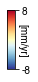

In [664]:
symbol_cbar_velo(vlim=['-8', '8'], font_size=10)

save to file: /net/kraken/nobak/ykliu/2022-BulkMotion/pic/insets/cbar_lat.pdf


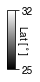

In [651]:
symbol_cbar_lat(vlim=['25', '32'], font_size=10)